# **Detecting malingering patterns in psychological tests**

## Cognitive, Behavioral and Social Sata project (2022-2023)

##### Atuthors: Bergamaschi Matteo (mat. 2041591), De Renzis Simone (mat. 2056102), Marchini Andrea (mat. 2044711), Varotto Davide (mat. 2056100)

##**Introduction**

A Psychological test is a standardized measure of a sample of a person’s
behaviour that is used in order to measure the individual differences that exist among people. These tests are used as a way of measuring differences between people or differences in the same person over time. Psychological tests are written, visual, or verbal evaluations administered to assess the cognitive and emotional functioning of candidates.

There are six main characteristics of a good psychological test:
1. Objectivity: the test should be free from subjective, like skill or knowledge, potentiality to be measured and evaluated;
2. Reliability: this refers to the extent to which they obtained results are consistent or reliable;
3. Validity: it refers to extent to which the test measures what it intends to measure. For example, if an intelligent test is developed to assess the level of intelligence, it shouldn't assess other factors;
4. Norms: Norms refer to the average performance of a sample on a given test;
5. Practicability: the test should not be too lengthy and difficult to
answer as well as scoring;
6. Standardization: the test procedures and steps must be conducted with consistency and under the same environment to achieve the same testing performance from those being tested.

When constructing a psychological test, we have to take into account the fact that people will try to lie to get "better" results. In particular, in some tests people will try to "fake good" (for example in test regarding job, child custody ecc.) or "fake bad" (for example in test regarding mental disorder for criminals). This is a serious problem, given the importance of the reasons why these tests are carried out. So finding the patterns in which people lie is an important task.

In this project we are going to try address this problem focusing on two points:


*   Find the the most robust model to detect dishonest responders from honest ones.
*   Find a robust method to select the most important questions for detecting malingering people.


We start importing libraries and defining some auxiliary functions we need to run the subsequent code.



In [ ]:
#@title

#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
import seaborn as sns
import xgboost as xgb
from scipy.stats import spearmanr
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from numpy.linalg import norm
from IPython.display import display, HTML
from collections import Counter

# setting a global seed to ensure reproducibility of the code
np.random.seed(123)

#this function extract the highest 20% numbers from a list
def select_top_20(features):
  temp = []
  for i,elem in enumerate(features):
    temp.append([elem, i])
  temp.sort(key = lambda x : -x[0])
  features = [elem[1] for elem in temp]
  top20 = math.ceil(len(temp)/5)
  temp = temp[0 : top20]
  res = [elem[1] for elem in temp]
  return features, res

# jaccard similarity between 2 lists
def jaccard_similarity(a, b):
    a = set(a)
    b = set(b)
    j = float(len(a.intersection(b))) / len(a.union(b))
    return j

#cosine similarity between 2 lists
def cosine_similarity(a,b):
  return np.dot(a,b)/(norm(a)*norm(b))

## Import Data

To ensure the robustness of these models and methods we are going to use a total of 15 different datasets:


*   DT_CC: imagining to be a parent that was undergoing a cause for the custody of his/her children -> faking good
*   DT_JI: a job interview that they cared a lot for -> faking good
*   PRMQ: developed to identify specific memory difficulties -> faking bad
*   PCL5: developed to identify possible victims of PTSD -> faking bad
*   NAQ_R: developed to identify possible victims of mobbing -> faking bad
*   PHQ9_GAD7: developed to identify possible victims of Anxious-depressive syndrome -> faking bad
*   PID5: developed to identify mental disorders -> faking bad
*   sPID-5: developed to identify mental disorders -> faking bad
*   PRFQ: specific caregivers' ability to mentalize with their children -> faking good
*   IESR: developed to identify possible victims of PTSD -> faking bad
*   DDDT: developed to identify Dark Triad personality traits -> faking good
*   IADQ: developed to identify adjustment disorder, a stress response syndrome -> faking bad
*   BF_CTU: a Job Interview for a Salesperson Position -> faking good
*   BF_OU: a role in a Humanitarian Organization -> faking good
*   BF_V: to obtain a Child Custody -> faking good



Every dataset has the same structure: every responder has to take the test twice, the first time truthfully, the second time simulating that they want to lie on the test in order to obtain better results. We start by importing the datasets:



In [ ]:
#@title
#import datasets
names = ["DT_CC","DT_JI","PRMQ","PCL5","NAQ_R","PHQ9_GAD7","PID5","sPID-5","PRFQ","IESR","DDDT","IADQ","BF_CTU","BF_OU","BF_V"]
sep = [0,1,0,1,1,1,1,0,0,0,0,0,0,0,0]
seps = [",",";"]
for name,sep in zip(names,sep):
  url = "https://raw.githubusercontent.com/Berga53/cognitive/main/{}.csv".format(name)
  #full dataset
  globals()[name] = pd.read_csv(url, sep=seps[sep])
  #only honests dataset
  globals()[name+"_honest"] = globals()[name][globals()[name]['CONDITION'] == 'H']
  #only dishonests dataset
  globals()[name+"_dishonest"] = globals()[name][globals()[name]['CONDITION'] == 'D']
  #set the same indexes to better compare honest and dishonest responses for every responder
  globals()[name+"_dishonest"].set_index(globals()[name+"_honest"].index, inplace = True)

#drop NAQ_R entries with condition "P", not involved in our research scope
NAQ_R = NAQ_R[(NAQ_R['CONDITION'] == 'H') | (NAQ_R['CONDITION'] == 'D')]

# split labes and data
for name in names:
  globals()[name + "_X"] = globals()[name].iloc[:,0:-1]
  globals()[name + "_X"]  = globals()[name + "_X"] .to_numpy()
  globals()[name + "_y"] = globals()[name]['CONDITION'].to_numpy()
  globals()[name + "_y"][globals()[name + "_y"] == "H"] = 0
  globals()[name + "_y"][globals()[name + "_y"] == "D"] = 1
  globals()[name + "_y"]=globals()[name + "_y"].astype('int')


## Exploratory Data Analysis


Exploratory data analysis (EDA) uses graphics and visualizations to explore and analyze a data set. The goal is to explore, investigate and learn, as opposed to confirming statistical hypotheses, to discover patterns,to spot anomalies and to check assumptions.

Now we perform some initial analysis of the dataset. Firstly, we are interested in seeing if some missing values are present.

In [ ]:
#@title
# check if datasets contain missing values
null = [globals()[name].isnull().sum().sum() for name in names]
print(f"{'Dataset' : <10}{'Missing values' : ^10}")
for i,name in enumerate(names):
  print(f"{name : <10}{null[i] : ^10}")

Dataset   Missing values
DT_CC         0     
DT_JI         0     
PRMQ          0     
PCL5          0     
NAQ_R         0     
PHQ9_GAD7     0     
PID5          0     
sPID-5        0     
PRFQ          0     
IESR          0     
DDDT          0     
IADQ          0     
BF_CTU        0     
BF_OU         0     
BF_V          0     


As we know, each participant filled the questionnaire twice: first honestly (condition "H") and then faking bad or good (condition "D"). We now ensure that the numbers of honest and dishonest samples coincide:

In [ ]:
#@title
# check number of honest and dishonest entries in every dataset
print("Is the number of samples in the honest condition equal to the one in the dishonest condition?: ")
for name in names:
  print(f"{name : <10}{str(globals()[name][globals()[name].CONDITION == 'H'].shape[0] == globals()[name][globals()[name].CONDITION == 'D'].shape[0]) : ^10}")


Is the number of samples in the honest condition equal to the one in the dishonest condition?: 
DT_CC        True   
DT_JI        True   
PRMQ         True   
PCL5         True   
NAQ_R        True   
PHQ9_GAD7    True   
PID5         True   
sPID-5       True   
PRFQ         True   
IESR         True   
DDDT         True   
IADQ         True   
BF_CTU       True   
BF_OU        True   
BF_V         True   


Now we look how many items (questions) and entries each dataset has. We also order the datasets by number of items.

In [ ]:
#@title

# order datasets by number of items
names.sort(key = lambda x : globals()[x].shape[-1])

# items per detaset
items = [globals()[name].shape[-1]-1 for name in names]
items_sum = np.array(items).sum()
print(f"{'Dataset' : <10}{'Items' : ^10}")
for i,name in enumerate(names):
  print(f"{name : <10}{items[i] : ^10}")


Dataset     Items   
IADQ          9     
BF_CTU        10    
BF_OU         10    
BF_V          10    
DDDT          12    
PRMQ          16    
PHQ9_GAD7     16    
PRFQ          18    
PCL5          20    
NAQ_R         22    
IESR          22    
sPID-5        25    
DT_CC         27    
DT_JI         27    
PID5         220    


In [ ]:
#@title
#entries per dataset
entries = []
print("Entries per dataset")
print(f"{'Dataset' : <10}{'Honest' : ^10}{'Dishonest' : ^10}{'Total' : ^10}")
for i,name in enumerate(names):
  a = globals()[name+"_honest"].shape[0]
  b = globals()[name+"_dishonest"].shape[0]
  print(f"{name : <10}{a : ^10}{b : ^10}{a+b : ^10}")
  entries.append(a+b)

Entries per dataset
Dataset     Honest  Dishonest   Total   
IADQ         225       225       450    
BF_CTU       221       221       442    
BF_OU        230       230       460    
BF_V         243       243       486    
DDDT         493       493       986    
PRMQ         702       702       1404   
PHQ9_GAD7    559       559       1118   
PRFQ         339       339       678    
PCL5         201       201       402    
NAQ_R        356       356       712    
IESR         179       179       358    
sPID-5       519       519       1038   
DT_CC        241       241       482    
DT_JI        432       432       864    
PID5         412       412       824    


Below, the mean, standard deviation and mode of the questions in each honest (H) and dishonest (D) dataset is computed. From it we can see that there is a significant difference between the values in the honest questionnaires statistics (H) and those in the faked questionnaires statistics (D). This difference is in most cases in the direction of an increasing score for the "fake bad" datasets and of a decreasing score for the "fake good" datasets.

In [ ]:
#@title

#compute mean of honest and dishonest responses accross datasets
q_means = []
for name in names:
  q_means.append([globals()[name+"_honest"].iloc[:,0:-1].stack().mean(),globals()[name+"_dishonest"].iloc[:,0:-1].stack().mean()])

#compute standard deviation of honest and dishonest responses accross datasets
q_std = []

for name in names:
  q_std.append([globals()[name+"_honest"].iloc[:,0:-1].stack().std(),globals()[name+"_dishonest"].iloc[:,0:-1].stack().std()])

#compute mode of honest and dishonest responses accross datasets
q_mode = []

for name in names:
  q_mode.append([int(globals()[name+"_honest"].iloc[:,0:-1].stack().mode()),int(globals()[name+"_dishonest"].iloc[:,0:-1].stack().mode())])

print(f"{'Dataset' : <15}{'H mean' : ^10}{'D mean' : ^10}{'H std' : ^10}{'D std' : ^10}{'H mode' : ^10}{'D mode' : ^10}")
for name, mean, std, mode in zip(names, q_means, q_std, q_mode):
  print(f"{name : <15}{round(mean[0],3) : ^10}{round(mean[1],3) : ^10}{round(std[0],3) : ^10}{round(std[1],3) : ^10}{mode[0] : ^10}{mode[1] : ^10}")

Dataset          H mean    D mean    H std     D std     H mode    D mode  
IADQ             2.453     3.694     1.113     0.607       3         4     
BF_CTU           3.314     3.922     1.182      1.14       4         5     
BF_OU             3.32     4.106     1.215     1.103       4         5     
BF_V             3.289     3.999     1.212      1.16       4         5     
DDDT             2.401     1.845      1.2       1.14       2         1     
PRMQ             2.428     4.036     1.151     1.308       2         5     
PHQ9_GAD7         2.27     4.407     1.184     0.931       1         5     
PRFQ             2.863     3.542     1.493     1.794       1         5     
PCL5             0.839      2.21      0.96     1.394       0         3     
NAQ_R             1.49     4.077     0.766     1.254       1         5     
IESR             1.837      3.87     1.043     1.237       1         5     
sPID-5           1.676     3.167     0.844      1.06       1         4     
DT_CC       

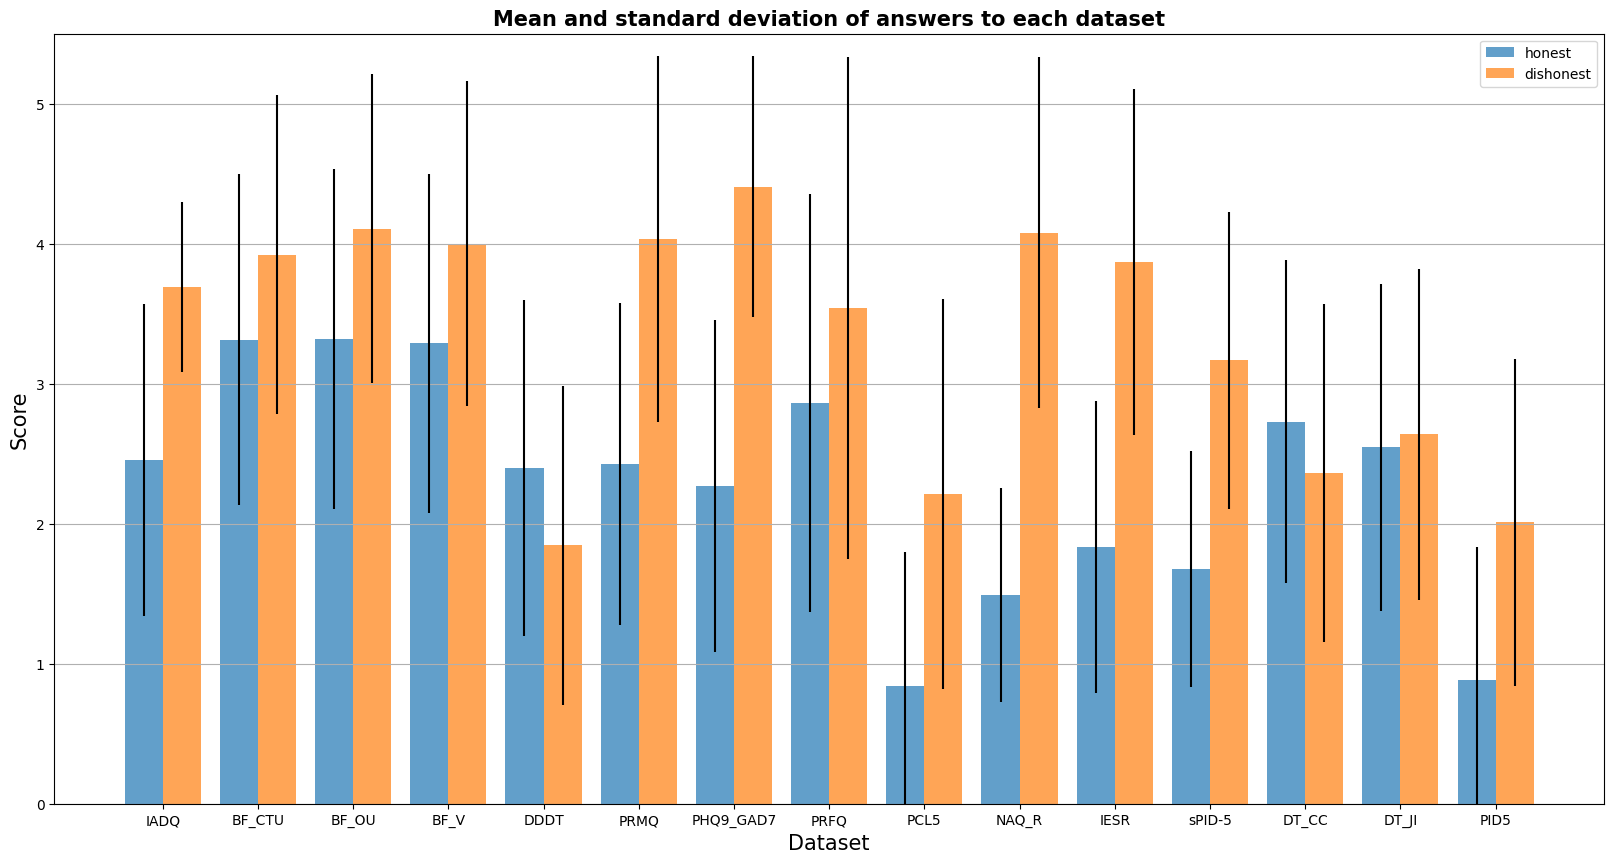

In [ ]:
#@title
# plot mean and std of every response accross datasets
plt.figure(figsize=(20,10))
plt.ylim(0,5.5)

X_axis = np.arange(len(names))
h = plt.bar(X_axis - 0.2, np.array(q_means)[:,0], 0.4, yerr = np.array(q_std)[:,0], alpha = 0.7, )
d = plt.bar(X_axis + 0.2, np.array(q_means)[:,1], 0.4, yerr = np.array(q_std)[:,1], color = "tab:orange", alpha = 0.7)

plt.xticks(X_axis, names)
plt.xlabel("Dataset", fontsize=15)
plt.ylabel("Score", fontsize=15)
plt.title("Mean and standard deviation of answers to each dataset", fontsize=15, fontweight='bold')
plt.legend((h, d),("honest", "dishonest"), prop={'size': 10})
plt.grid(axis="y", zorder = 0)
plt.show()

Below we can see a visualization of the response distribution accross dataset. We can note that in  some dataset, like NAQ_R, honest and dishonest responses have very distinct distribution, while in others, like DT_JI, the distributions appears very similar. We can expect that in the former finding the malingering patterns will be easier, while in the latter it will be a difficult task.

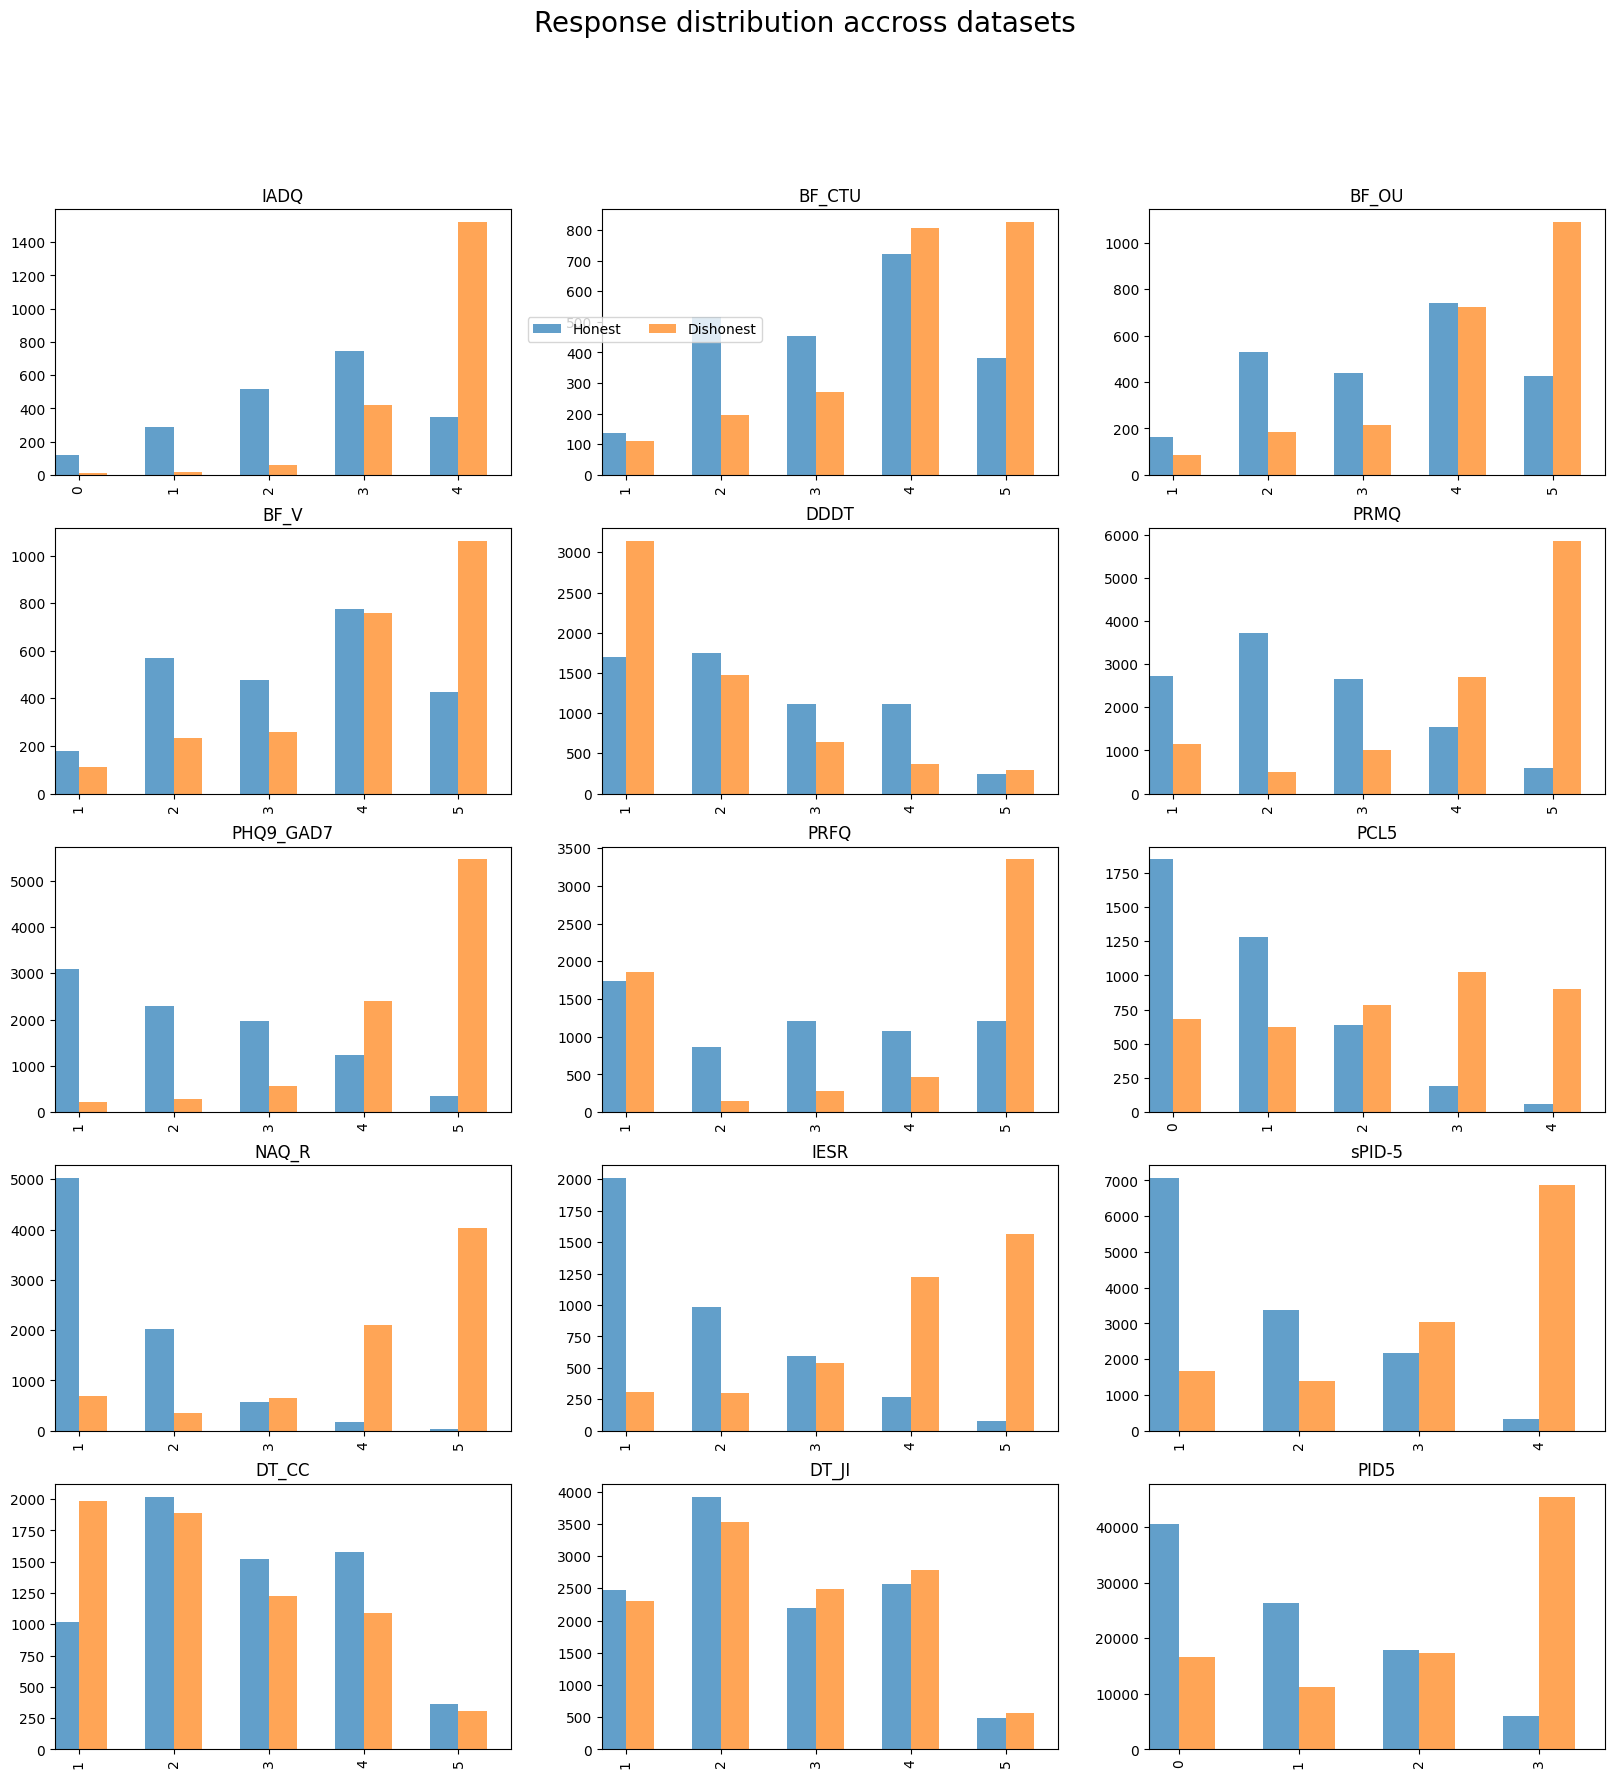

In [ ]:
#@title
#plot distribution of responses accross datasets

nrows = 5
ncols = 3

fig = plt.figure(figsize=(20, 20))
axes = fig.subplots(nrows=nrows, ncols=ncols)

for i in range(nrows):
    for j in range(ncols):
      n = i*ncols+j
      ax = axes[i][j]
      globals()[names[n]+"_honest"].iloc[:,0:-1].stack().value_counts().sort_index().plot(ax = ax, kind = 'bar', position = 1, width = 0.3, alpha = 0.7)
      globals()[names[n]+"_dishonest"].iloc[:,0:-1].stack().value_counts().sort_index().plot(ax = ax, kind = 'bar', color = "tab:orange", position = 0, width = 0.3, alpha = 0.7)
      ax.set_title(names[n])

fig.suptitle("Response distribution accross datasets", fontsize=20)
fig.legend(["Honest","Dishonest"], loc = 10, bbox_to_anchor= (0.42, 0.82), ncol = 2)
plt.show()

Below we can observe the absolute mean difference between honest and dishonest responses accross every question of every dataset. Also we indicate positive differences with blue bars while the negative ones with orange bars. We can note that in "fake good" datasets we have a majority of positive difference, while this is the opposite in "fake bad" datasets. In particular we expect that questions with high absolute mean difference will be more important for the classification.

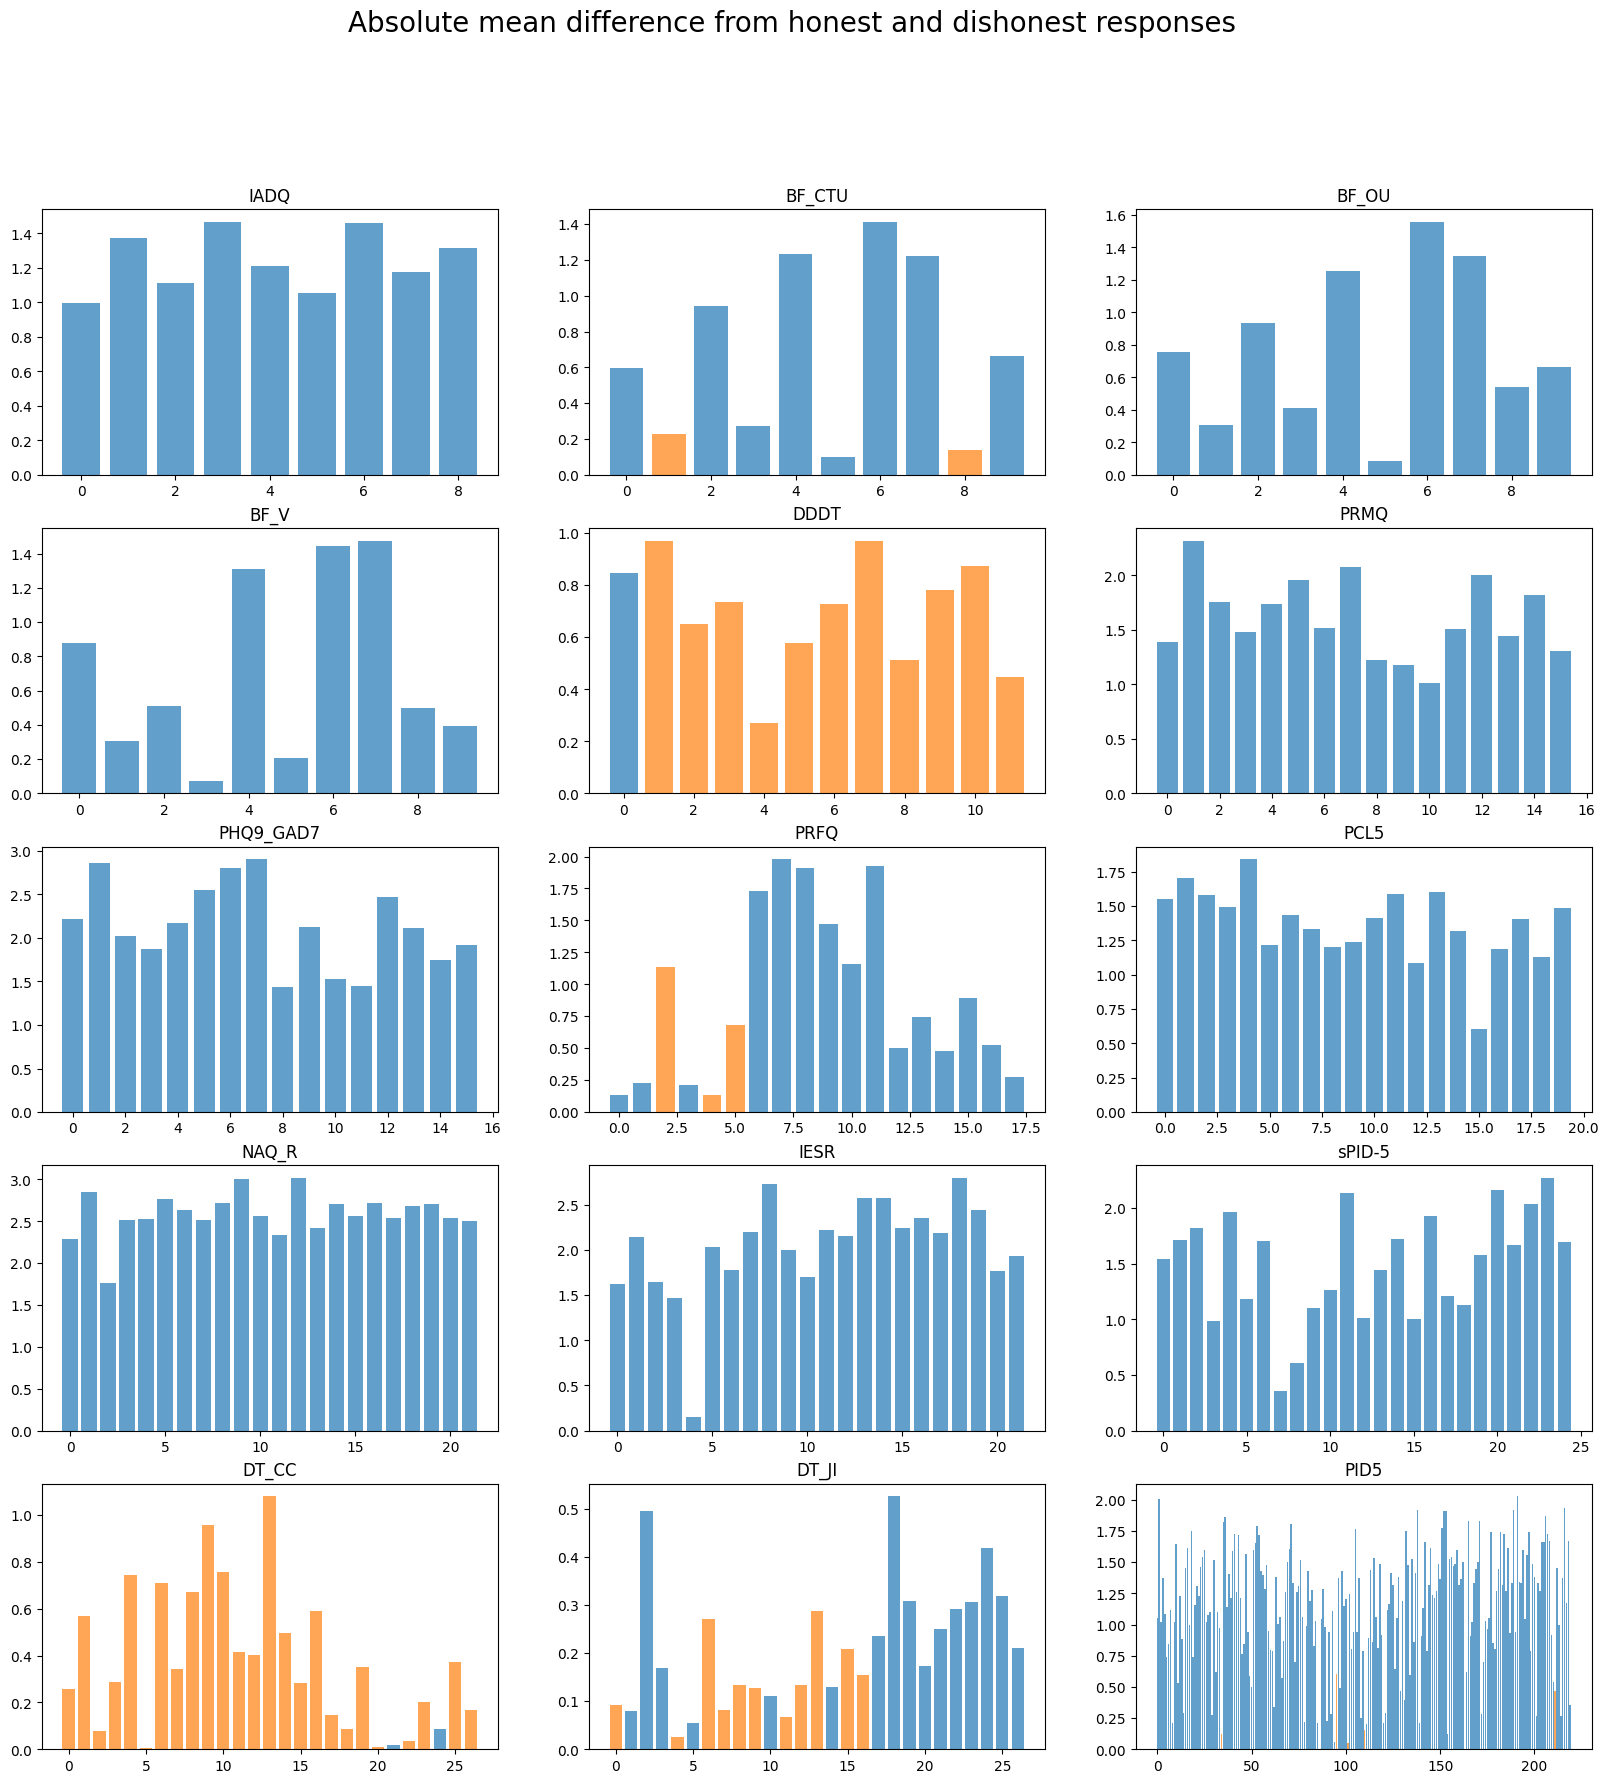

In [ ]:
#@title
# mean differences from honest and dishonest responses
diff = []
for name in names:
  temp = globals()[name+"_dishonest"].iloc[:,0:-1].subtract(globals()[name+"_honest"].iloc[:,0:-1]).values
  diff.append(np.mean(temp, axis = 0))

nrows = 5
ncols = 3

fig = plt.figure(figsize=(20, 20))
axes = fig.subplots(nrows=nrows, ncols=ncols)

for i in range(nrows):
    for j in range(ncols):
      n = i*ncols+j
      colors = []
      for elem in diff[n]:
        if elem > 0 :
          colors.append("tab:blue")
        else:
          colors.append("tab:orange")
      ax = axes[i][j]
      ax.bar(np.arange(items[n]),abs(diff[n]),color = colors, alpha = 0.7)
      ax.set_title(names[n])


fig.suptitle("Absolute mean difference from honest and dishonest responses", fontsize=20)
plt.show()

Below we can see the percentage of honest responses that were respectively increased, decreased or unchanged in the corresponding dishonest responses. Again we expect that in "fake bad" datasets we are going to see that the majority of the responses were increased, while the opposite for the "fake good" datasets.

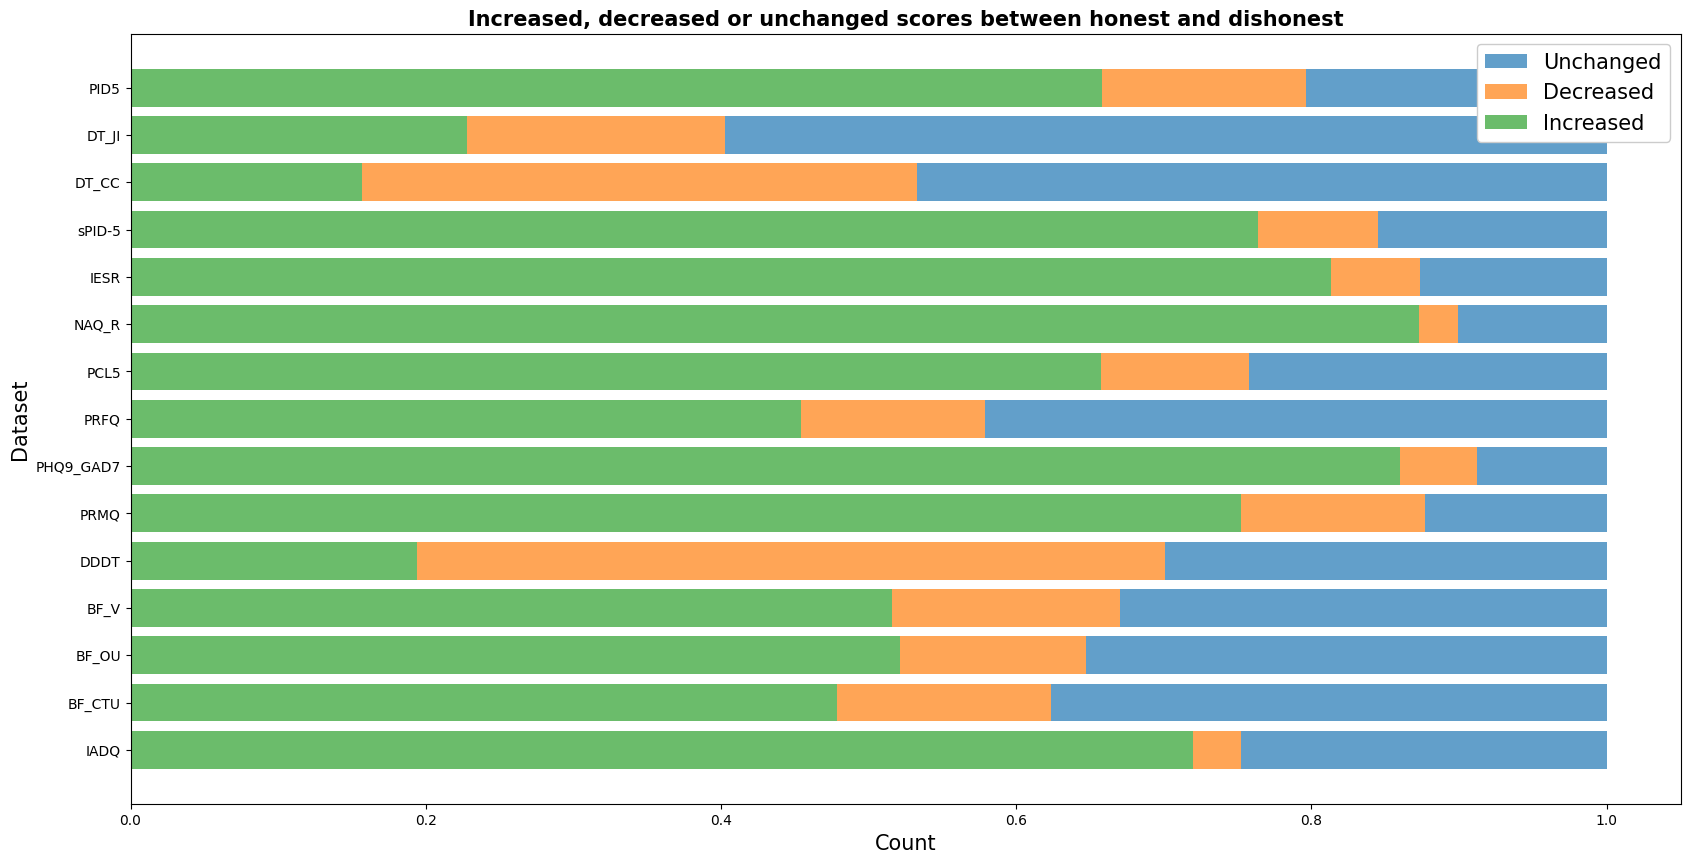

In [ ]:
#@title
# compute the percentage of responses unchanged and increased
unchanged = []
increased = []
decreased = []

for name in names:
  temp = globals()[name+"_dishonest"].iloc[:,0:-1].subtract(globals()[name+"_honest"].iloc[:,0:-1]).values
  tot = temp.shape[0]*temp.shape[1]
  unchanged.append(np.sum(np.sum(temp == 0, axis=0))/tot)
  increased.append(np.sum(np.sum(temp > 0, axis=0))/tot)
  decreased.append(np.sum(np.sum(temp < 0, axis=0))/tot)

sum = list(np.array(increased) + np.array(decreased))

#plot
plt.figure(figsize=(20,10))

plt.barh(y = names, width = unchanged, left = sum, alpha=0.7)
plt.barh(y = names, width = decreased, left = increased, alpha=0.7)
plt.barh(y = names, width = increased, alpha=0.7)
plt.legend(['Unchanged', 'Decreased', 'Increased'], framealpha=1, prop={'size': 15})

plt.ylabel("Dataset", fontsize=15)
plt.xlabel("Count", fontsize=15)
plt.title("Increased, decreased or unchanged scores between honest and dishonest", fontsize=15, fontweight='bold')
plt.show()

Finally we can see a 2D visualization of every datasets, done using PCA with only 2 component. Looking on how the honest and dishonest clusters are close and entangled we can have an idea on the difficulty of the dataset.

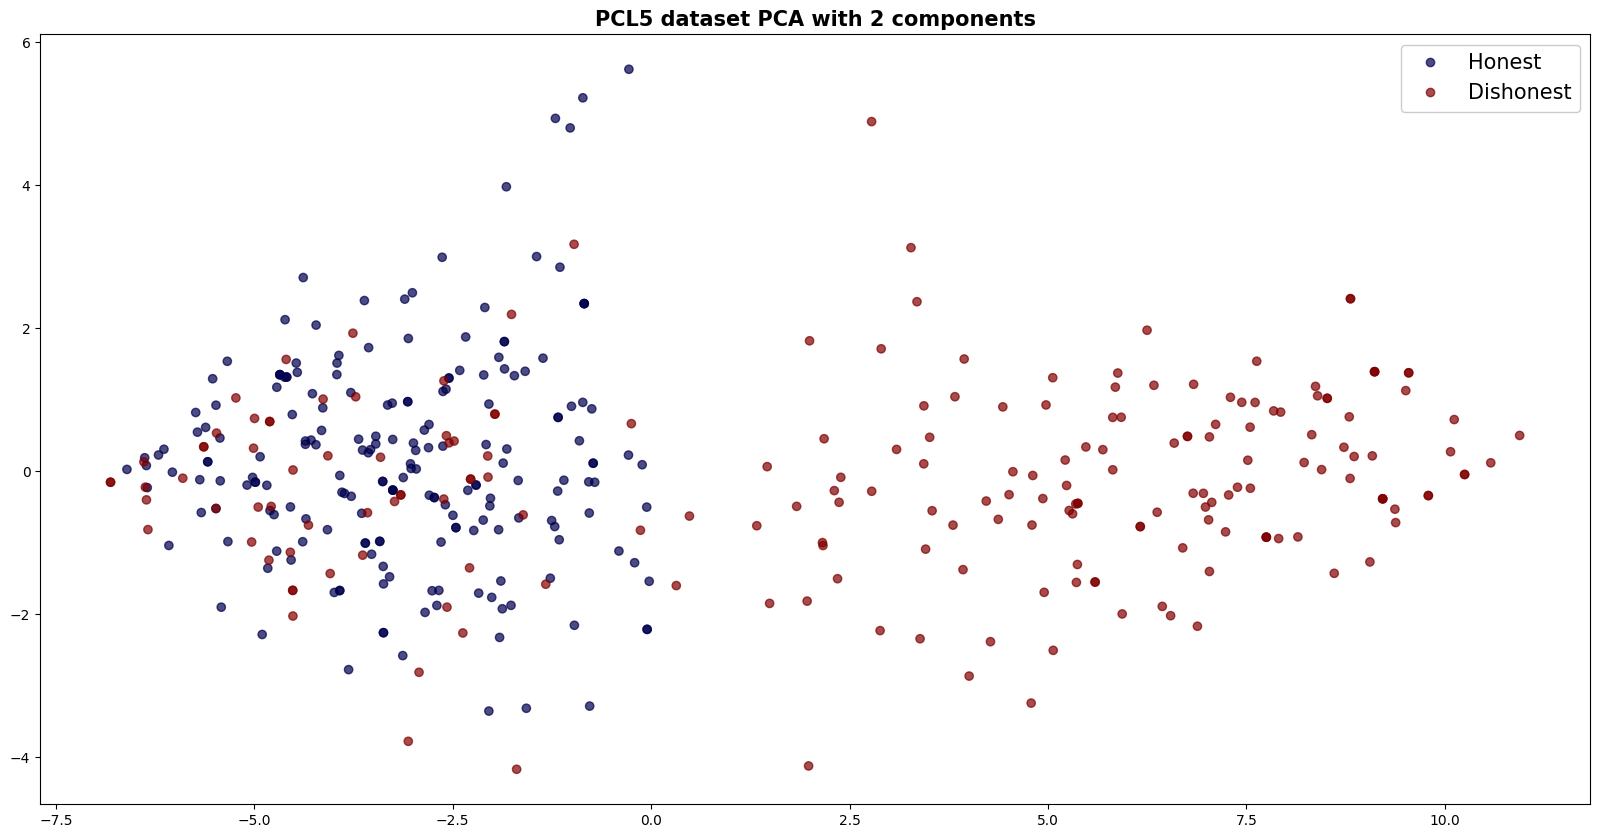

In [ ]:
#@title
Dataset = "PCL5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
pca = PCA(n_components = 2)
pca.fit(globals()[Dataset + "_X"])
temp = pca.transform(globals()[Dataset + "_X"])
plt.figure(figsize=(20,10))
scatter = plt.scatter(x = temp[:,0], y = temp[:,1], c = globals()[Dataset]["CONDITION"], cmap = 'seismic', alpha = 0.7)
plt.title(Dataset + " dataset PCA with 2 components", fontsize=15, fontweight='bold')
plt.legend(handles=scatter.legend_elements()[0], labels=['Honest','Dishonest'], framealpha=1, prop={'size': 15})
plt.show()

## Preprocessing

In this part we searched for people who didn't really committed to fake the responsens when they were supposed to do that. So we decided to drop people who gave the identical or almost identical answers in both honest and dishonest condition. With almost identical answers we refer to people who only changed their responses by 1 in at most the 10% (rounded up) of the questions.  

In [ ]:
# Find people who responded almost equally in both qestionnaires
lazy = []

for n,name in enumerate(names):
  temp = globals()[name + "_dishonest"].iloc[:,0:-1].subtract(globals()[name + "_honest"].iloc[:,0:-1])
  k = int(np.ceil(items[n]/10))
  lazy.append(temp[temp.abs().sum(axis=1) <= k].index.values.tolist())
  t = globals()[name + "_honest"].shape[0]

  # drop lazy people
  drop = []
  for elem in lazy[n]:
    drop.append(elem)
    drop.append(elem + t)
  globals()[name + "_honest"] = globals()[name + "_honest"].drop(globals()[name + "_honest"].index[lazy[n]])
  globals()[name + "_dishonest"] = globals()[name + "_dishonest"].drop(globals()[name + "_dishonest"].index[lazy[n]])
  globals()[name] = globals()[name].drop(globals()[name].index[drop])

  # adjust indexes
  globals()[name + "_honest"].index = [i for i in range(globals()[name + "_honest"].shape[0])]
  globals()[name + "_dishonest"].index = [i for i in range(globals()[name + "_dishonest"].shape[0])]
  globals()[name].index = [i for i in range(globals()[name].shape[0])]

# print number of entries dropped and new numbers of entries
entries = []
print("Entries Dropped")
print(f"{'Dataset' : <10}{'Lazy' : ^10}{'Honest' : ^10}{'Dishonest' : ^10}{'New total' : ^10}")
for i,name in enumerate(names):
  a = globals()[name+"_honest"].shape[0]
  b = globals()[name+"_dishonest"].shape[0]
  print(f"{name : <10}{len(lazy[i]) : ^10}{a : ^10}{b : ^10}{a+b : ^10}")
  entries.append(a+b)

Entries Dropped
Dataset      Lazy     Honest  Dishonest New total 
IADQ          10       215       215       430    
BF_CTU        5        216       216       432    
BF_OU         4        226       226       452    
BF_V          3        240       240       480    
DDDT          3        490       490       980    
PRMQ          0        702       702       1404   
PHQ9_GAD7     0        559       559       1118   
PRFQ          1        338       338       676    
PCL5          2        199       199       398    
NAQ_R         14       342       342       684    
IESR          1        178       178       356    
sPID-5        2        517       517       1034   
DT_CC         10       231       231       462    
DT_JI         17       415       415       830    
PID5          0        412       412       824    


Finally, we standardize data in range [0,1] and then we split in train and test set:

In [ ]:
#@title

# split labes and data
for name in names:
  globals()[name + "_X"] = globals()[name].iloc[:,0:-1]
  globals()[name + "_X"]  = globals()[name + "_X"] .to_numpy()
  globals()[name + "_y"] = globals()[name]['CONDITION'].to_numpy()
  globals()[name + "_y"][globals()[name + "_y"] == "H"] = 0
  globals()[name + "_y"][globals()[name + "_y"] == "D"] = 1
  globals()[name + "_y"]=globals()[name + "_y"].astype('int')

# standardize data
for name in names:
  scaler = MinMaxScaler()
  (globals()[name + "_X"]) = scaler.fit_transform(globals()[name + "_X"])

# split data in train and test sets
  globals()[name + "_X_train_val"], globals()[name + "_X_test"], globals()[name + "_y_train_val"], globals()[name + "_y_test"] = train_test_split(globals()[name + "_X"], globals()[name + "_y"], test_size = 0.10, shuffle = True, random_state = 0)


## Malingering Classifiers
In this section we are going to train and select the different models we want to use to detecte malingering people. In paritcular we are using six different classifiers:


*   Random Forest
*   Decision Tree
*   Support Vector Machine
*   k-Nearest Neighbor
*   XGBoost
*   Logistic Regression

For every classifier we are using the same pipeline:


1.   Define the parameter grid.
2.   Run a different grid search for every dataset. In particular we are using GridSearchCV from the Sklearn library, and we cross validate using 5 folds.
3.   Retrain the best model on all the train and validation set and evaluate it on the previously selected test set. We decided that since every dataset is balanced, accuracy score is the best evaluation metric.
4.   Save the best model and parameters for subsequent uses.



In [ ]:
#@title
models = ["forest", "tree", "svc", "knn","xgb","logistic"]
best_params = pd.DataFrame(index = names)

### Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

For the parameter grid we focused on number of estimators and maximum depth of the trees.

In [ ]:
#@title
forest_top_models = []
forest_results_temp = []
params = []

for index,name in enumerate(names):
  #define parameters grid
  grid_params = {
    'n_estimators': [20, 40, 60, 80],
    'criterion': ['entropy'],
    'max_depth': [None,1,2,3,4,5,6,7,8,9,10]}

  #find best estimator using cross validation over the parameter grid
  model = GridSearchCV(RandomForestClassifier(), grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model.fit(globals()[name + "_X_train_val"], globals()[name + "_y_train_val"])

  #evaluate the best estimator over the test set
  y_pred_forest = model.best_estimator_.predict(globals()[name + "_X_test"])
  acc = accuracy_score(globals()[name + "_y_test"], y_pred_forest)

  #store results and best parameters in a dataframe
  forest_top_models.append(model.best_estimator_)
  forest_results_temp.append([name, model.best_score_, acc])
  params.append(model.best_params_)

forest_results = pd.DataFrame(forest_results_temp, columns = ["Dataset", "Validation accuracy", "Test accuracy"])
best_params["forest"] = params

In [ ]:
#display results
display(HTML(forest_results.to_html()))

,Dataset,Validation accuracy,Test accuracy
0,IADQ,0.868198,0.883721
1,BF_CTU,0.840293,0.909091
2,BF_OU,0.869347,0.717391
3,BF_V,0.837958,0.854167
4,DDDT,0.817431,0.785714
5,PRMQ,0.935081,0.907801
6,PHQ9_GAD7,0.989065,1.000000
7,PRFQ,0.909497,0.926471
8,PCL5,0.846244,0.825000
9,NAQ_R,0.973984,0.985507


### Support Vector Machine

Support vector machine is a linear model to perform classification tasks. One main advantage of this model is that it can also perform non-linear classification by specifying a different kernel to be used.

In particular we searched among two tipes of kernel: linear and rbf (Radial Basis Function). The other parameter we focused on is the regularization parameter C.

In [ ]:
#@title
svc_top_models = []
svc_results_temp = []
params = []

for index,name in enumerate(names):
  #define parameters grid
  grid_params = {
    'C': [1,0.1,0.01,0.001],
    'kernel': ['rbf','linear'],}

  #find best estimator using cross validation over the parameter grid
  model = GridSearchCV(SVC(), grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model.fit(globals()[name + "_X_train_val"], globals()[name + "_y_train_val"])

  #evaluate the best estimator over the test set
  y_pred_svc = model.best_estimator_.predict(globals()[name + "_X_test"])
  acc = accuracy_score(globals()[name + "_y_test"], y_pred_svc)

  #store results and best parameters in a dataframe
  svc_top_models.append(model.best_estimator_)
  svc_results_temp.append([name, model.best_score_, acc])
  params.append(model.best_params_)

svc_results = pd.DataFrame(svc_results_temp, columns = ["Dataset", "Validation accuracy", "Test accuracy"])
best_params["svc"] = params

In [ ]:
#display results
display(HTML(svc_results.to_html()))

,Dataset,Validation accuracy,Test accuracy
0,IADQ,0.860440,0.883721
1,BF_CTU,0.837629,0.931818
2,BF_OU,0.869377,0.847826
3,BF_V,0.826464,0.854167
4,DDDT,0.800449,0.744898
5,PRMQ,0.913702,0.929078
6,PHQ9_GAD7,0.990055,1.000000
7,PRFQ,0.904620,0.926471
8,PCL5,0.846166,0.850000
9,NAQ_R,0.973984,0.985507


### Decision Tree

A decision tree is a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks. It has a hierarchical, tree structure, which consists of a root node, branches, internal nodes and leaf nodes.

For this model we focused only on the maximum depth of the tree.


In [ ]:
#@title
tree_top_models = []
tree_results_temp = []
params = []

for index,name in enumerate(names):
  #define parameters grid
  grid_params = {
    'criterion': ['entropy'],
    'max_depth': [None,1,2,3,4,5,6,7,8,9,10]}

  #find best estimator using cross validation over the parameter grid
  model = GridSearchCV(DecisionTreeClassifier(), grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model.fit(globals()[name + "_X_train_val"], globals()[name + "_y_train_val"])

  #evaluate the best estimator over the test set
  y_pred_tree = model.best_estimator_.predict(globals()[name + "_X_test"])
  acc = accuracy_score(globals()[name + "_y_test"], y_pred_tree)

  #store results and best parameters in a dataframe
  tree_top_models.append(model.best_estimator_)
  tree_results_temp.append([name, model.best_score_, acc])
  params.append(model.best_params_)

tree_results = pd.DataFrame(tree_results_temp, columns = ["Dataset", "Validation accuracy", "Test accuracy"])
best_params["tree"] = params

In [ ]:
#display results
display(HTML(tree_results.to_html()))

,Dataset,Validation accuracy,Test accuracy
0,IADQ,0.855178,0.813953
1,BF_CTU,0.829903,0.863636
2,BF_OU,0.837398,0.760870
3,BF_V,0.791633,0.750000
4,DDDT,0.772053,0.683673
5,PRMQ,0.898661,0.879433
6,PHQ9_GAD7,0.972164,1.000000
7,PRFQ,0.866780,0.882353
8,PCL5,0.821088,0.800000
9,NAQ_R,0.959350,0.956522


### k-Nearest Neighbors

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

Of course the most important parameter of k-NN is the number of neighbors voting, so we focused on that one.

In [ ]:
#@title
knn_top_models = []
knn_results_temp = []
params = []

for index,name in enumerate(names):
  #define parameters grid
  grid_params = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),}

  #find best estimator using cross validation over the parameter grid
  model = GridSearchCV(KNeighborsClassifier(), grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model.fit(globals()[name + "_X_train_val"], globals()[name + "_y_train_val"])

  #evaluate the best estimator over the test set
  y_pred_knn = model.best_estimator_.predict(globals()[name + "_X_test"])
  acc = accuracy_score(globals()[name + "_y_test"], y_pred_knn)

  #store results and best parameters in a dataframe
  knn_top_models.append(model.best_estimator_)
  knn_results_temp.append([name, model.best_score_, acc])
  params.append(model.best_params_)

knn_results = pd.DataFrame(knn_results_temp, columns = ["Dataset", "Validation accuracy", "Test accuracy"])
best_params["knn"] = params

In [ ]:
#display results
display(HTML(knn_results.to_html()))

,Dataset,Validation accuracy,Test accuracy
0,IADQ,0.855245,0.860465
1,BF_CTU,0.827373,0.863636
2,BF_OU,0.834869,0.760870
3,BF_V,0.826276,0.812500
4,DDDT,0.783417,0.775510
5,PRMQ,0.904182,0.822695
6,PHQ9_GAD7,0.986084,1.000000
7,PRFQ,0.909552,0.955882
8,PCL5,0.837793,0.825000
9,NAQ_R,0.975610,0.985507


### XGBoost

XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting framework at its core. Gradient boosting is a machine learning technique used in regression and classification tasks. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. A weak learner is one which is slightly better than random guessing.

Similarly as for the Random Forest, we focused on number of estimators and maximum depth of the trees.

In [ ]:
#@title
xgb_top_models = []
xgb_results_temp = []
params = []

for index,name in enumerate(names):
  #define parameters grid
  grid_params = {
    'n_estimators': [20 ,40, 60, 80],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],}

  #find best estimator using cross validation over the parameter grid
  model = GridSearchCV(xgb.XGBClassifier(), grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model.fit(globals()[name + "_X_train_val"], globals()[name + "_y_train_val"])

  #evaluate the best estimator over the test set
  y_pred_xgb = model.best_estimator_.predict(globals()[name + "_X_test"])
  acc = accuracy_score(globals()[name + "_y_test"], y_pred_xgb)

  #store results and best parameters in a dataframe
  xgb_top_models.append(model.best_estimator_)
  xgb_results_temp.append([name, model.best_score_, acc])
  params.append(model.best_params_)

xgb_results = pd.DataFrame(xgb_results_temp, columns = ["Dataset", "Validation accuracy", "Test accuracy"])
best_params["xgb"] = params

In [ ]:
#display results
display(HTML(xgb_results.to_html()))

,Dataset,Validation accuracy,Test accuracy
0,IADQ,0.868132,0.883721
1,BF_CTU,0.832601,0.909091
2,BF_OU,0.859530,0.739130
3,BF_V,0.833414,0.854167
4,DDDT,0.815158,0.785714
5,PRMQ,0.933506,0.893617
6,PHQ9_GAD7,0.988074,1.000000
7,PRFQ,0.901301,0.926471
8,PCL5,0.818545,0.850000
9,NAQ_R,0.973984,0.985507


### Logistic Regression

Logistic regression is a linear model for binary classification taks. Given an input  x  the logisitc regression computes  P(y=1|x) , i.e. the probability that the point  x  belongs to class  1 . Of course, since there are just two classes and exploiting the property that probabilities sum up to one, the probability that the input belongs to class  0  can be recovered by computing:  1−P(y=1|x) . The standard threshold to decide whether the point belongs to class  0  or  1  is  0.5.

For the parameter grid we mainly focused on the regularization parameter C.

In [ ]:
#@title
logistic_top_models = []
logistic_results_temp = []
params = []

for index,name in enumerate(names):
  #define parameters grid
  grid_params = {
    'C': [1,0.1,0.01,0.001],}

  #find best estimator using cross validation over the parameter grid
  model = GridSearchCV(LogisticRegression(), grid_params, n_jobs= -1, cv = 5, return_train_score = True)
  model.fit(globals()[name + "_X_train_val"], globals()[name + "_y_train_val"])

  #evaluate the best estimator over the test set
  y_pred_logistic = model.best_estimator_.predict(globals()[name + "_X_test"])
  acc = accuracy_score(globals()[name + "_y_test"], y_pred_logistic)

  #store results and best parameters in a dataframe
  logistic_top_models.append(model.best_estimator_)
  logistic_results_temp.append([name, model.best_score_, acc])
  params.append(model.best_params_)

logistic_results = pd.DataFrame(logistic_results_temp, columns = ["Dataset", "Validation accuracy", "Test accuracy"])
best_params["logistic"] = params

In [ ]:
#display results
display(HTML(logistic_results.to_html()))

,Dataset,Validation accuracy,Test accuracy
0,IADQ,0.857809,0.883721
1,BF_CTU,0.835098,0.931818
2,BF_OU,0.847185,0.782609
3,BF_V,0.819326,0.875000
4,DDDT,0.767546,0.765306
5,PRMQ,0.905778,0.886525
6,PHQ9_GAD7,0.988070,1.000000
7,PRFQ,0.898035,0.926471
8,PCL5,0.848983,0.850000
9,NAQ_R,0.973984,0.985507


### Results

Below we can see the average accuracy accross datasets for every model. We can see that all models but Decision Tree achieve a mean of 85% accuracy. In particular the best performing model seems to be SVC followed by Logistic Regression.

In [ ]:
#@title
print("Average accuracy on all datasets")
print(f"{'Model' : <20}{'Validation' : ^15}{ 'Test' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,1].mean(), 3) : ^15}{round(forest_results.iloc[:,2].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,1].mean(), 3) : ^15}{round(tree_results.iloc[:,2].mean(), 3) : ^15}")
print(f"{'SVC' : <20}{round(svc_results.iloc[:,1].mean(), 3) : ^15}{round(svc_results.iloc[:,2].mean(), 3) : ^15}")
print(f"{'KNN' : <20}{round(knn_results.iloc[:,1].mean(), 3) : ^15}{round(knn_results.iloc[:,2].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,1].mean(), 3) : ^15}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,1].mean(), 3) : ^15}{round(logistic_results.iloc[:,2].mean(), 3) : ^15}")

Average accuracy on all datasets
Model                 Validation        Test      
Random Forest            0.881          0.871     
Decision Tree            0.847          0.833     
SVC                      0.875          0.883     
KNN                      0.859          0.849     
XgBoost                  0.876          0.873     
Logistic Regression      0.869          0.876     


Another interesting metric is how well the models performed on average on a specific dataset. Below we can see the average of the six models performance on every dataset. Thos gives an idea of how much every dataset is difficult. We can observe that there is a group of datasets, and in particular DT_JI and DT_CC, that seems a lot more challenging.

In [ ]:
#@title
print("Average accuracy of all models on very dataset")
print(f"{'Dataset' : <20}{'Validation' : ^15}{ 'Test' : ^15}")
for i,name in enumerate(names):
  val = []
  test = []

  for model in models:
    val.append(globals()[model + "_results"].iloc[i,1])
    test.append(globals()[model + "_results"].iloc[i,2])
  print(f"{name : <20}{round(np.mean(val), 3) : ^15}{round(np.mean(test), 3) : ^15}")

Average accuracy of all models on very dataset
Dataset               Validation        Test      
IADQ                     0.861          0.868     
BF_CTU                   0.834          0.902     
BF_OU                    0.853          0.768     
BF_V                     0.823          0.833     
DDDT                     0.793          0.757     
PRMQ                     0.915          0.887     
PHQ9_GAD7                0.986           1.0      
PRFQ                     0.898          0.924     
PCL5                     0.836          0.833     
NAQ_R                    0.972          0.981     
IESR                     0.941          0.926     
sPID-5                   0.96           0.987     
DT_CC                    0.751          0.691     
DT_JI                    0.648          0.657     
PID5                     0.948          0.952     


In the following plot we can visualize the accuracies achieved by our models over a specific dataset.

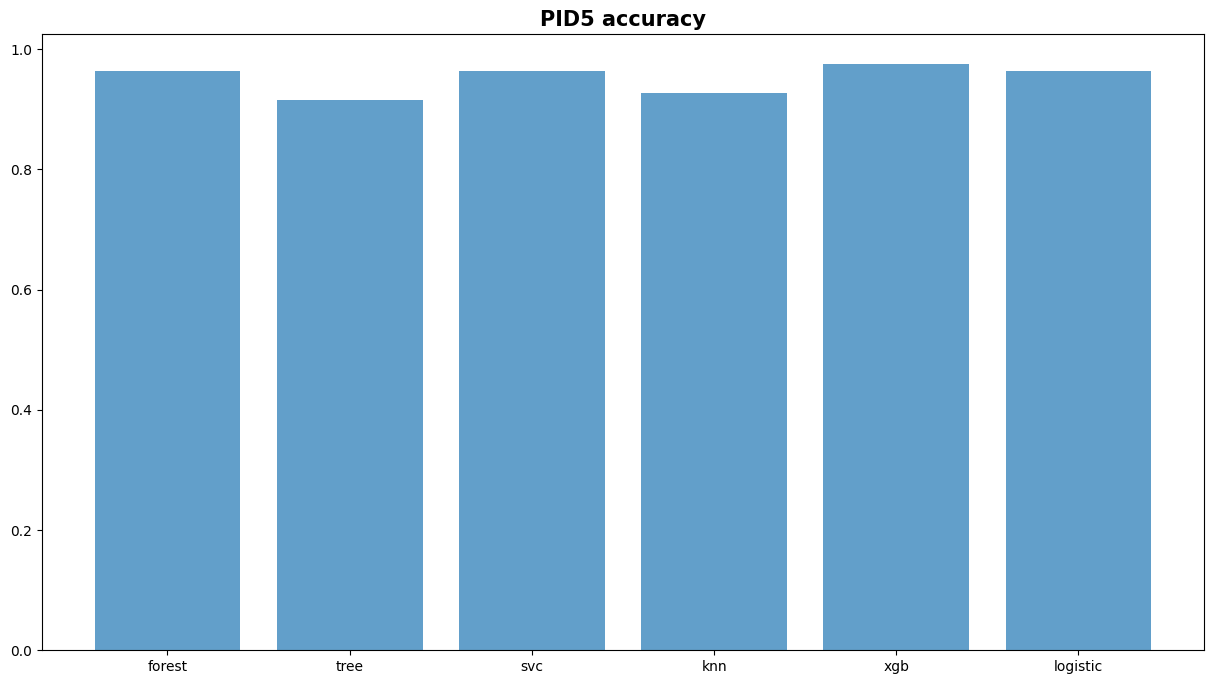

In [ ]:
#@title
Dataset = "PID5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
i = names.index(Dataset)
temp = []
for model in models:
  temp.append(globals()[model + "_results"].iloc[i,2])
plt.figure(figsize=(15,8))
plt.bar(models, temp, alpha = 0.7)
plt.title(Dataset + " accuracy", fontsize=15, fontweight='bold')
plt.show()

In the following table we can visualize the best sets of parameters, chosen by cross-validation

In [ ]:
display(HTML(best_params.to_html()))

,forest,svc,tree,knn,xgb,logistic
IADQ,"{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 20}","{'C': 0.1, 'kernel': 'linear'}","{'criterion': 'entropy', 'max_depth': 4}",{'n_neighbors': 5},"{'max_depth': 2, 'n_estimators': 20}",{'C': 0.1}
BF_CTU,"{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 40}","{'C': 0.1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 3}",{'n_neighbors': 5},"{'max_depth': 1, 'n_estimators': 20}",{'C': 0.1}
BF_OU,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 40}","{'C': 1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 3}",{'n_neighbors': 4},"{'max_depth': 9, 'n_estimators': 20}",{'C': 1}
BF_V,"{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 60}","{'C': 1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 7}",{'n_neighbors': 9},"{'max_depth': 3, 'n_estimators': 20}",{'C': 0.01}
DDDT,"{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 80}","{'C': 1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 6}",{'n_neighbors': 10},"{'max_depth': 2, 'n_estimators': 40}",{'C': 0.01}
PRMQ,"{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 40}","{'C': 1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 8}",{'n_neighbors': 5},"{'max_depth': 3, 'n_estimators': 80}",{'C': 0.1}
PHQ9_GAD7,"{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 60}","{'C': 1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 7}",{'n_neighbors': 7},"{'max_depth': 1, 'n_estimators': 60}",{'C': 1}
PRFQ,"{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 60}","{'C': 0.1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 3}",{'n_neighbors': 8},"{'max_depth': 1, 'n_estimators': 20}",{'C': 0.001}
PCL5,"{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 40}","{'C': 0.1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 4}",{'n_neighbors': 10},"{'max_depth': 5, 'n_estimators': 80}",{'C': 0.001}
NAQ_R,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 60}","{'C': 1, 'kernel': 'rbf'}","{'criterion': 'entropy', 'max_depth': 5}",{'n_neighbors': 5},"{'max_depth': 1, 'n_estimators': 20}",{'C': 1}



## Features Selection
The objective of this section is to find the best items to discriminate honest answers from dishonest ones.
In particular, we want to restrict the number of questions to 20% of the total, rounded up.
In order to do that, we focus on 5 different methods:


*   Correlation
*   Permutation importance
*   Naive method
*   PCA
*   Built-in Methods



### Correlation

In this part, we simply select the best items by looking at their Pearson correlation coefficients with the condition variable.

In [ ]:
#@title
#top 20% by correlation
top_20_corr = []
top_corr = []

#we iterate over all datasets
for n,name in enumerate(names):
  #find correlation coefficients between items columns and condition column
  temp = [np.corrcoef(globals()[name + "_X_train_val"][:,i],globals()[name + "_y_train_val"])[0][1] for i in range(items[n])]

  #extract top 20% item's indexes
  top_20_corr.append(select_top_20(temp)[1])
  top_corr.append(select_top_20(temp)[0])

#retrain and evaluate on the test set best models only on top 20% items by correlation
for name_model in models:
  acc = []
  for n,name in enumerate(names):
    model = globals()[name_model + "_top_models"][n]
    model.fit(globals()[name + "_X_train_val"][:,top_20_corr[n]], globals()[name + "_y_train_val"])
    y_pred = model.predict(globals()[name + "_X_test"][:,top_20_corr[n]])
    acc.append(accuracy_score(globals()[name + "_y_test"], y_pred))
  globals()[name_model + "_results"]["corr accuracy"] = acc

In [ ]:
#@title
#display accuracies obtained over the test set
print("Average accuracy on datasets")
print(f"{'Model' : <20}{'All items' : ^15}{ 'Top 20% corr' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,2].mean(), 3) : ^15}{round(forest_results.iloc[:,3].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,2].mean(), 3) : ^15}{round(tree_results.iloc[:,3].mean(), 3) : ^15}")
print(f"{'SVC' : <20}{round(svc_results.iloc[:,2].mean(), 3) : ^15}{round(svc_results.iloc[:,3].mean(), 3) : ^15}")
print(f"{'KNN' : <20}{round(knn_results.iloc[:,2].mean(), 3) : ^15}{round(knn_results.iloc[:,3].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}{round(xgb_results.iloc[:,3].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,2].mean(), 3) : ^15}{round(logistic_results.iloc[:,3].mean(), 3) : ^15}")

Average accuracy on datasets
Model                  All items    Top 20% corr  
Random Forest            0.871          0.818     
Decision Tree            0.833          0.82      
SVC                      0.883          0.823     
KNN                      0.849          0.81      
XgBoost                  0.873          0.83      
Logistic Regression      0.876          0.832     


The following plot shows the comparisons between the accuracies achieved by the models on a specific dataset.


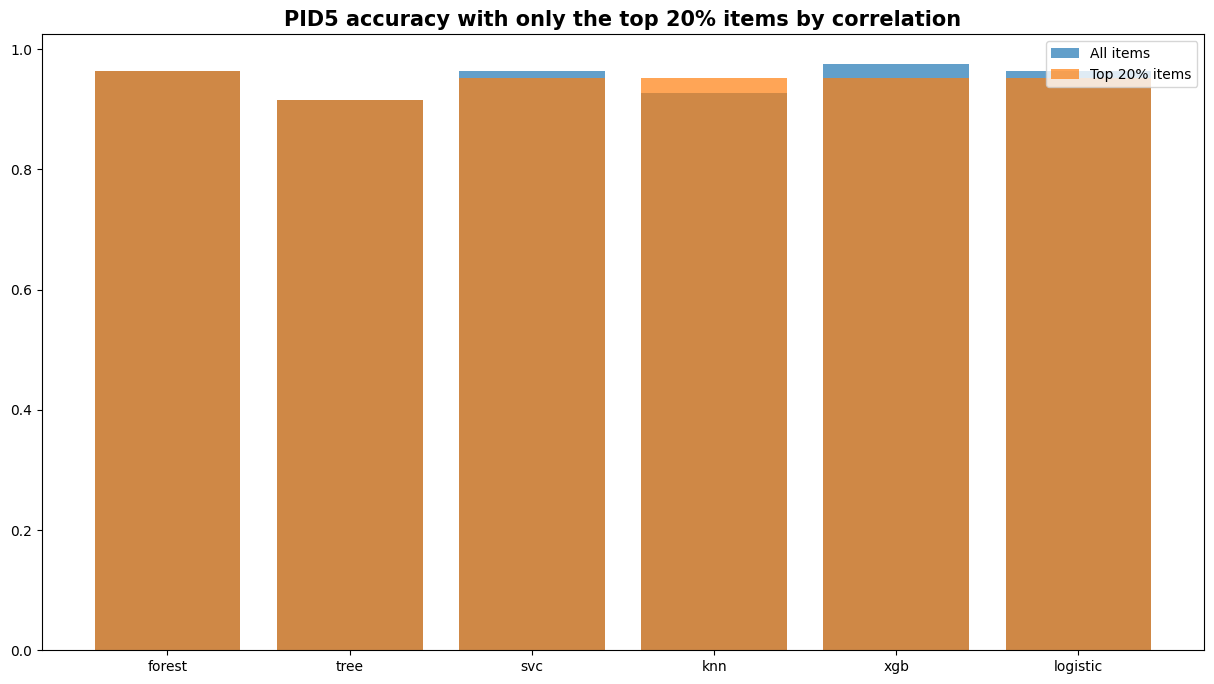

In [ ]:
#@title

Dataset = "PID5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
i = names.index(Dataset)
all = []
top_20 = []
for model in models:
  all.append(globals()[model + "_results"].iloc[i,2])
  top_20.append(globals()[model + "_results"].iloc[i,3])

plt.figure(figsize=(15,8))
plt.bar(models, all, alpha = 0.7, label = "All items")
plt.bar(models, top_20, alpha = 0.7, label = "Top 20% items")
plt.legend()
plt.title(Dataset + " accuracy with only the top 20% items by correlation", fontsize=15, fontweight='bold')
plt.show()

### Permutation Importance

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

In [ ]:
#@title
#top 20% by permutation importance

#we iterate over all models
for name_model in models:

  globals()[name_model + "_top_20_perm"] = []
  globals()[name_model + "_to_perm"] = []

  #we iterate over all datasets
  for i, name in enumerate(names):
    globals()[name_model + "_top_models"][i].fit(globals()[name + "_X_train_val"],globals()[name + "_y_train_val"] )
    #get permutation importance for every item
    permutations = permutation_importance(globals()[name_model + "_top_models"][i], globals()[name + "_X_train_val"], globals()[name + "_y_train_val"], scoring='accuracy', n_repeats = 20)

    #extract top 20% item's indexes
    features, features20 = select_top_20(permutations.importances_mean)
    globals()[name_model + "_top_20_perm"].append(features20)
    globals()[name_model + "_to_perm"].append(features)

#retrain and evaluate on the test set best models only on top 20% items by permutation importance
for name_model in models:
  acc = []
  for n,name in enumerate(names):
    model = globals()[name_model + "_top_models"][n]
    model.fit(globals()[name + "_X_train_val"][:,globals()[name_model + "_top_20_perm"][n]], globals()[name + "_y_train_val"])
    y_pred = model.predict(globals()[name + "_X_test"][:,globals()[name_model + "_top_20_perm"][n]])
    acc.append(accuracy_score(globals()[name + "_y_test"], y_pred))
  globals()[name_model + "_results"]["perm accuracy"] = acc

In [ ]:
#@title
#display accuracies obtained over the test set

print("Average accuracy on datasets")
print(f"{'Model' : <20}{'All' : ^15}{ 'Top 20% perm' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,2].mean(), 3) : ^15}{round(forest_results.iloc[:,4].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,2].mean(), 3) : ^15}{round(tree_results.iloc[:,4].mean(), 3) : ^15}")
print(f"{'SVC' : <20}{round(svc_results.iloc[:,2].mean(), 3) : ^15}{round(svc_results.iloc[:,4].mean(), 3) : ^15}")
print(f"{'KNN' : <20}{round(knn_results.iloc[:,2].mean(), 3) : ^15}{round(knn_results.iloc[:,4].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}{round(xgb_results.iloc[:,4].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,3].mean(), 3) : ^15}{round(logistic_results.iloc[:,4].mean(), 3) : ^15}")

Average accuracy on datasets
Model                     All       Top 20% perm  
Random Forest            0.871          0.845     
Decision Tree            0.833          0.828     
SVC                      0.883          0.855     
KNN                      0.849          0.846     
XgBoost                  0.873          0.848     
Logistic Regression      0.832          0.836     


The following plot shows the comparisons between the accuracies achieved by the models on a specific dataset.

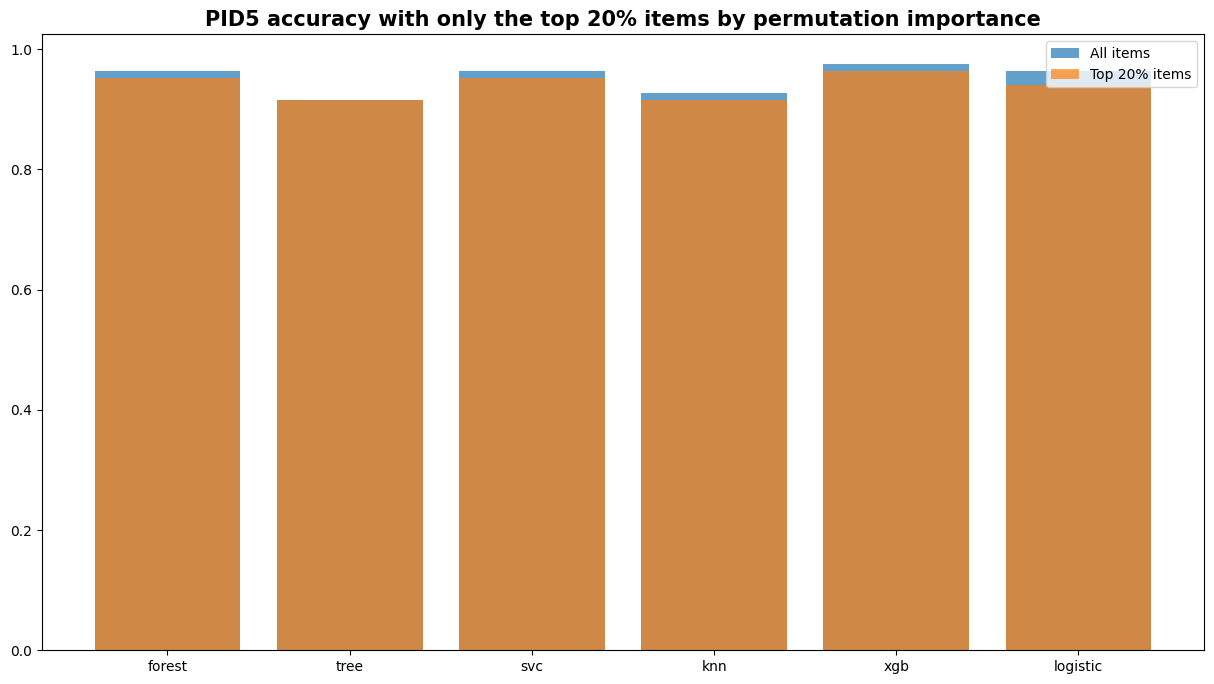

In [ ]:
#@title
Dataset = "PID5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
i = names.index(Dataset)
all = []
top_20 = []
for model in models:
  all.append(globals()[model + "_results"].iloc[i,2])
  top_20.append(globals()[model + "_results"].iloc[i,4])

plt.figure(figsize=(15,8))
plt.bar(models, all, alpha = 0.7, label = "All items")
plt.bar(models, top_20, alpha = 0.7, label = "Top 20% items")
plt.legend()
plt.title(Dataset + " accuracy with only the top 20% items by permutation importance", fontsize=15, fontweight='bold')
plt.show()

### Naive Method
In this part we are selecting the most relevant items using a simple naive method that we implemented.
It consists in finding and selecting the items which have the highest mean absolute gap between honest and dishonest answer.


We believe that the questions with the highest gaps are felt as more important from the participants, so probably they carry more information about malingering patterns.

In [ ]:
#@title
#top 20% naive method

top_20_naive = []
top_naive = []
#we iterate over all datasets
for i,name in enumerate(names):
  #we calculate the mean gap (in absolute value) between honest and dishonest answers, for every item
  temp = globals()[name+"_dishonest"].iloc[:,0:-1].subtract(globals()[name+"_honest"].iloc[:,0:-1]).values
  diff = abs(np.mean(temp, axis = 0))

  #extract top 20% item's indexes
  top_20_naive.append(select_top_20(diff)[1])
  top_naive.append(select_top_20(diff)[0])

#retrain and evaluate on the test set best models only on top 20% items selected before
for name_model in models:
  acc = []
  for i,name in enumerate(names):
    model = globals()[name_model + "_top_models"][i]
    model.fit(globals()[name + "_X_train_val"][:,top_20_naive[i]], globals()[name + "_y_train_val"])
    y_pred = model.predict(globals()[name + "_X_test"][:,top_20_naive[i]])
    acc.append(accuracy_score(globals()[name + "_y_test"], y_pred))

  globals()[name_model + "_results"]["naive accuracy"] = acc

In [ ]:
#@title
#display accuracies obtained over the test set

print("Average accuracy on datasets")
print(f"{'Model' : <20}{'All' : ^15}{ 'Top 20% diff' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,2].mean(), 3) : ^15}{round(forest_results.iloc[:,5].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,2].mean(), 3) : ^15}{round(tree_results.iloc[:,5].mean(), 3) : ^15}")
print(f"{'SVC' : <20}{round(svc_results.iloc[:,2].mean(), 3) : ^15}{round(svc_results.iloc[:,5].mean(), 3) : ^15}")
print(f"{'KNN' : <20}{round(knn_results.iloc[:,2].mean(), 3) : ^15}{round(knn_results.iloc[:,5].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}{round(xgb_results.iloc[:,5].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,2].mean(), 3) : ^15}{round(logistic_results.iloc[:,5].mean(), 3) : ^15}")

Average accuracy on datasets
Model                     All       Top 20% diff  
Random Forest            0.871          0.849     
Decision Tree            0.833          0.835     
SVC                      0.883          0.842     
KNN                      0.849          0.834     
XgBoost                  0.873          0.85      
Logistic Regression      0.876          0.849     


The following plot shows the comparisons between the accuracies achieved by the models on a specific dataset.

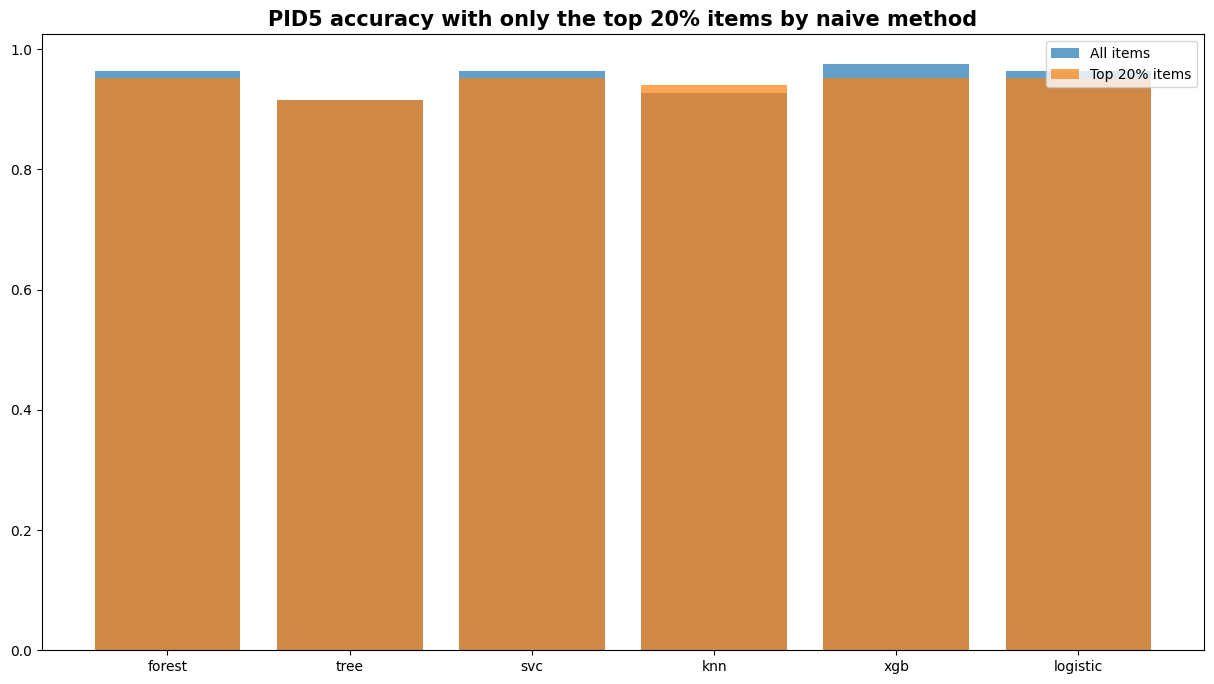

In [ ]:
#@title
Dataset = "PID5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
i = names.index(Dataset)
all = []
top_20 = []
for model in models:
  all.append(globals()[model + "_results"].iloc[i,2])
  top_20.append(globals()[model + "_results"].iloc[i,5])

plt.figure(figsize=(15,8))
plt.bar(models, all, alpha = 0.7, label = "All items")
plt.bar(models, top_20, alpha = 0.7, label = "Top 20% items")
plt.legend()
plt.title(Dataset + " accuracy with only the top 20% items by naive method", fontsize=15, fontweight='bold')
plt.show()

### PCA

PCA (Principal Component Analysis) is s method used to reduce the dimensionality of a dataset.
It decomposes a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance.

By looking at the questions that contribute most to the explanation of variance in PCA, we can select the most relevant items.

In [ ]:
#@title
# top 20 pca
top_20_pca = []
top_pca = []

#we iterate over all datasets
for index,name in enumerate(names):
  #fit PCA on dataset
  pca = PCA(n_components = int(np.ceil(items[index]/5)))
  pca.fit(globals()[name + "_X_train_val"])
  #get the variance explanation index list
  var = pca.explained_variance_
  con = pca.transform(np.eye(items[index]))
  w_con = (var*con).T.sum(axis=0)

  #extract top 20% item's indexes
  top_20_pca.append(select_top_20(w_con)[1])
  top_pca.append(select_top_20(w_con)[0])

#retrain and evaluate on the test set best models only on top 20% items selected by PCA
for name_model in models:
  acc = []
  for i,name in enumerate(names):
    model = globals()[name_model + "_top_models"][i]
    model.fit(globals()[name + "_X_train_val"][:,top_20_pca[i]], globals()[name + "_y_train_val"])
    y_pred = model.predict(globals()[name + "_X_test"][:,top_20_pca[i]])
    acc.append(accuracy_score(globals()[name + "_y_test"], y_pred))

  globals()[name_model + "_results"]["pca accuracy"] = acc

In [ ]:
#@title
#display accuracies obtained over the test set

print("Average accuracy on datasets")
print(f"{'Model' : <20}{'All' : ^15}{ 'Top 20% pca' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,2].mean(), 3) : ^15}{round(forest_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,2].mean(), 3) : ^15}{round(tree_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'SVC' : <20}{round(svc_results.iloc[:,2].mean(), 3) : ^15}{round(svc_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'KNN' : <20}{round(knn_results.iloc[:,2].mean(), 3) : ^15}{round(knn_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}{round(xgb_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,2].mean(), 3) : ^15}{round(logistic_results.iloc[:,6].mean(), 3) : ^15}")

Average accuracy on datasets
Model                     All        Top 20% pca  
Random Forest            0.871          0.788     
Decision Tree            0.833          0.776     
SVC                      0.883          0.765     
KNN                      0.849          0.764     
XgBoost                  0.873          0.788     
Logistic Regression      0.876          0.763     


The following plot shows the comparisons between the accuracies achieved by the models on a specific dataset.

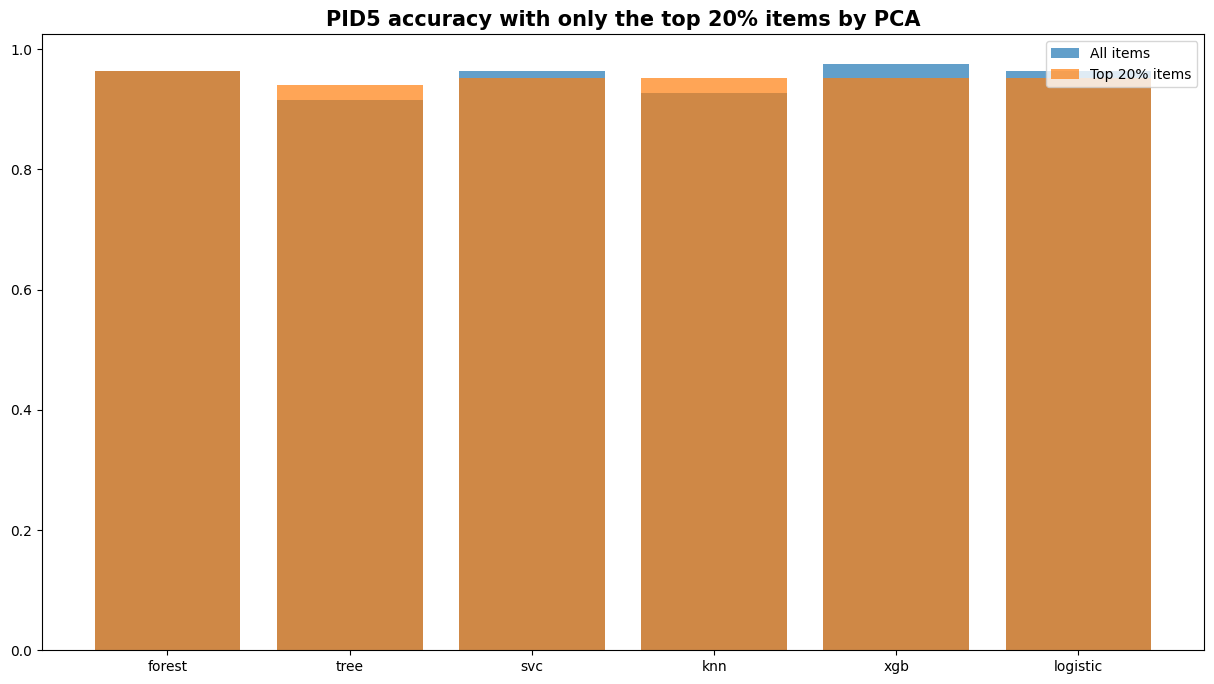

In [ ]:
#@title
Dataset = "PID5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
i = names.index(Dataset)
all = []
top_20 = []
for model in models:
  all.append(globals()[model + "_results"].iloc[i,2])
  top_20.append(globals()[model + "_results"].iloc[i,6])

plt.figure(figsize=(15,8))
plt.bar(models, all, alpha = 0.7, label = "All items")
plt.bar(models, top_20, alpha = 0.7, label = "Top 20% items")
plt.legend()
plt.title(Dataset + " accuracy with only the top 20% items by PCA", fontsize=15, fontweight='bold')
plt.show()

### Built-in Methods

In this section, we are considering built-in methods to extract the most relevant features. To go more into detail:


*   logistic regression: we took into account the items related to the highest coefficients (in absolute value) for the regression.
*   random forest, decision tree and XGBoost: these models already provide metrics about items' relevance.

SVC and k-NN were not considered in this section, since they do not give metrics about items' relevance.

In [ ]:
#@title
#top 20% built-in

#we iterate over models
for name_model in models:

  #we skip these two models
  if name_model == "knn" or name_model == "svc":
    continue

  #case of logistic regression
  elif name_model == "logistic":

    globals()[name_model + "_top_20_built_in"] = []
    globals()[name_model + "_to_built_in"] = []

    #iterate over all datasets
    for i, name in enumerate(names):
      #get regression coefficients for every item
      model = globals()[name_model + "_top_models"][i]
      model.fit(globals()[name + "_X_train_val"],globals()[name + "_y_train_val"] )
      features, features20 = select_top_20(abs(model.coef_[0]))

      #extract top 20% item's indexes
      globals()[name_model + "_top_20_built_in"].append(features20)
      globals()[name_model + "_to_built_in"].append(features)

  #other cases: random forest, decision tree and XGBoost
  else:

    globals()[name_model + "_top_20_built_in"] = []
    globals()[name_model + "_to_built_in"] = []

    #iterate over all datasets
    for i, name in enumerate(names):
      #get features importance
      model = globals()[name_model + "_top_models"][i]
      model.fit(globals()[name + "_X_train_val"],globals()[name + "_y_train_val"] )

      #extract top 20% item's indexes
      features, features20 = select_top_20(model.feature_importances_)
      globals()[name_model + "_top_20_built_in"].append(features20)
      globals()[name_model + "_to_built_in"].append(features)

#retrain and evaluate on the test set best models only on top 20% items selected by built-in methods
for name_model in models:
  acc = []
  if name_model == "knn" or name_model == "svc":
    continue

  for n,name in enumerate(names):
    model = globals()[name_model + "_top_models"][n]
    model.fit(globals()[name + "_X_train_val"][:,globals()[name_model + "_top_20_built_in"][n]], globals()[name + "_y_train_val"])
    y_pred = model.predict(globals()[name + "_X_test"][:,globals()[name_model + "_top_20_built_in"][n]])
    acc.append(accuracy_score(globals()[name + "_y_test"], y_pred))

  globals()[name_model + "_results"]["built in accuracy"] = acc

In [ ]:
#@title
#display accuracies obtained over the test set

print("Average accuracy on datasets")
print(f"{'Model' : <20}{'All' : ^15}{ 'Top 20% built in' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,2].mean(), 3) : ^15}{round(forest_results.iloc[:,7].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,2].mean(), 3) : ^15}{round(tree_results.iloc[:,7].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}{round(xgb_results.iloc[:,7].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,2].mean(), 3) : ^15}{round(logistic_results.iloc[:,7].mean(), 3) : ^15}")

Average accuracy on datasets
Model                     All      Top 20% built in
Random Forest            0.871          0.842     
Decision Tree            0.833          0.826     
XgBoost                  0.873          0.862     
Logistic Regression      0.876          0.854     


The following plot shows the comparisons between the accuracies achieved by the models on a specific dataset.

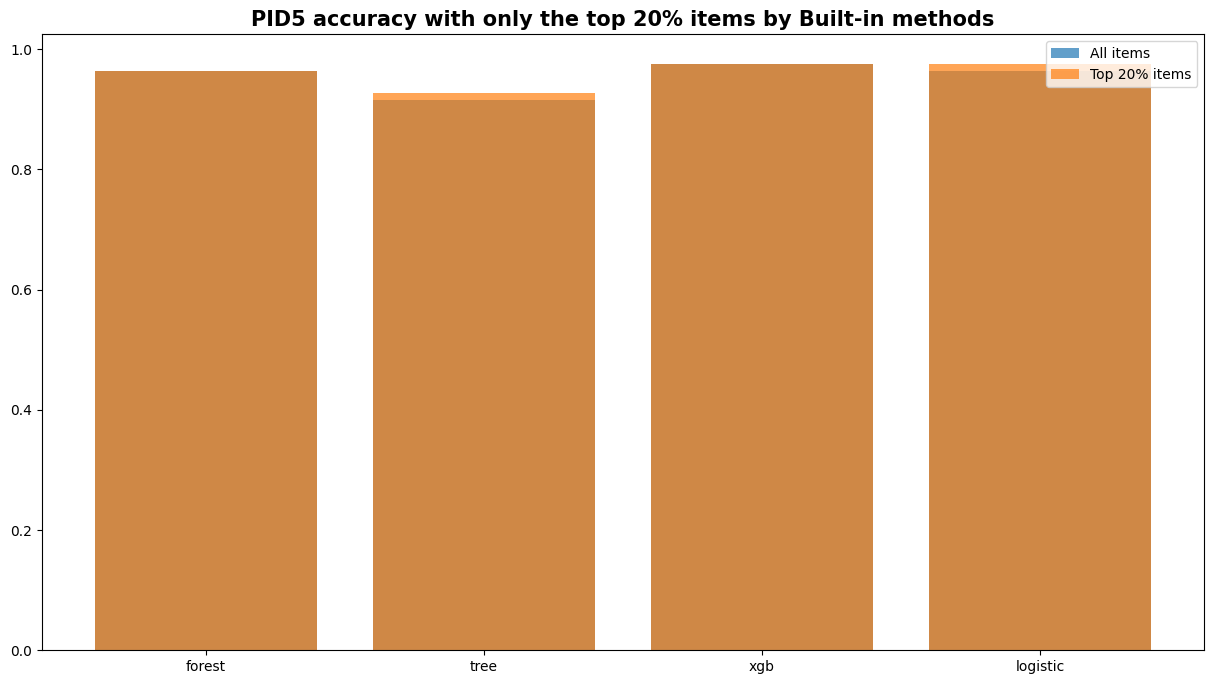

In [ ]:
#@title
Dataset = "PID5" #@param ['IADQ','BF_CTU','BF_OU','BF_V','DDDT','PRMQ','PHQ9_GAD7','PRFQ','PCL5','NAQ_R','IESR','sPID-5','DT_CC','DT_JI','PID5']
if Dataset not in names:
  print("Wrong dataset name")
i = names.index(Dataset)
all = []
top_20 = []
for model in models:
  if model == "knn" or model == "svc":
    continue
  else:
    all.append(globals()[model + "_results"].iloc[i,2])
    top_20.append(globals()[model + "_results"].iloc[i,7])
temp = ["forest", "tree","xgb","logistic"]
plt.figure(figsize=(15,8))
plt.bar(temp, all, alpha = 0.7, label = "All items")
plt.bar(temp, top_20, alpha = 0.7, label = "Top 20% items")
plt.legend()
plt.title(Dataset + " accuracy with only the top 20% items by Built-in methods", fontsize=15, fontweight='bold')
plt.show()

### Results



Below we can see a comparison between the results achieved by our feature selection methods. To summarize, the better methods seems to be the permutation importance and the naive ones. The built-in and correlation methods worked fine as expected, while the PCA method achieved the worst results.

In [ ]:
#@title
#print the average accuracies obtained by model-method pairs
print("Average accuracy on datasets")
print(f"{'Model' : <20}{'All features' : ^15}{ 'Top 20% corr' : ^15}{ 'Top 20% perm' : ^15}{ 'Top 20% naive' : ^15}{ 'Top 20% pca' : ^15}{ 'Top 20% built in' : ^15}")
print(f"{'Random Forest' : <20}{round(forest_results.iloc[:,2].mean(), 3) : ^15}{round(forest_results.iloc[:,3].mean(), 3) : ^15}{round(forest_results.iloc[:,4].mean(), 3) : ^15}{round(forest_results.iloc[:,5].mean(), 3) : ^15}{round(forest_results.iloc[:,6].mean(), 3) : ^15}{round(forest_results.iloc[:,7].mean(), 3) : ^15}")
print(f"{'Decision Tree' : <20}{round(tree_results.iloc[:,2].mean(), 3) : ^15}{round(tree_results.iloc[:,3].mean(), 3) : ^15}{round(tree_results.iloc[:,4].mean(), 3) : ^15}{round(tree_results.iloc[:,5].mean(), 3) : ^15}{round(tree_results.iloc[:,6].mean(), 3) : ^15}{round(tree_results.iloc[:,7].mean(), 3) : ^15}")
print(f"{'SVC' : <20}{round(svc_results.iloc[:,2].mean(), 3) : ^15}{round(svc_results.iloc[:,3].mean(), 3) : ^15}{round(svc_results.iloc[:,4].mean(), 3) : ^15}{round(svc_results.iloc[:,5].mean(), 3) : ^15}{round(svc_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'KNN' : <20}{round(knn_results.iloc[:,2].mean(), 3) : ^15}{round(knn_results.iloc[:,3].mean(), 3) : ^15}{round(knn_results.iloc[:,4].mean(), 3) : ^15}{round(knn_results.iloc[:,5].mean(), 3) : ^15}{round(knn_results.iloc[:,6].mean(), 3) : ^15}")
print(f"{'XgBoost' : <20}{round(xgb_results.iloc[:,2].mean(), 3) : ^15}{round(xgb_results.iloc[:,3].mean(), 3) : ^15}{round(xgb_results.iloc[:,4].mean(), 3) : ^15}{round(xgb_results.iloc[:,5].mean(), 3) : ^15}{round(xgb_results.iloc[:,6].mean(), 3) : ^15}{round(xgb_results.iloc[:,7].mean(), 3) : ^15}")
print(f"{'Logistic Regression' : <20}{round(logistic_results.iloc[:,2].mean(), 3) : ^15}{round(logistic_results.iloc[:,3].mean(), 3) : ^15}{round(logistic_results.iloc[:,4].mean(), 3) : ^15}{round(logistic_results.iloc[:,5].mean(), 3) : ^15}{round(logistic_results.iloc[:,6].mean(), 3) : ^15}{round(logistic_results.iloc[:,7].mean(), 3) : ^15}")

Average accuracy on datasets
Model                All features   Top 20% corr   Top 20% perm   Top 20% naive   Top 20% pca  Top 20% built in
Random Forest            0.871          0.818          0.845          0.849          0.788          0.842     
Decision Tree            0.833          0.82           0.828          0.835          0.776          0.826     
SVC                      0.883          0.823          0.855          0.842          0.765     
KNN                      0.849          0.81           0.846          0.834          0.764     
XgBoost                  0.873          0.83           0.848          0.85           0.788          0.862     
Logistic Regression      0.876          0.832          0.836          0.849          0.763          0.854     


 ## Features Selection Analysis

 In this section we analyse how the different methods select the top 20% most relevant items. In particular, we will use these metrcs:


*   Mean ratio of common items: simply the mean of the common elements between two lists of items, across all datasets.
*   Jaccard similarity: defined as the size of the intersection divided by the size of the union of two lists.
$$J(A,B) = \frac{|A ∩ B|}{|A ∪ B|}  $$
*   Cosine similarity: defined as the cosine of the angle between two vectors, that is, the dot product of the vectors divided by the product of their lengths.
$$S_C(A,B) = \frac{A \cdot B}{\|A\|\|B\|} $$



In [ ]:
lists = ["top_20_corr", "forest_top_20_perm", "tree_top_20_perm", "svc_top_20_perm", "knn_top_20_perm", "xgb_top_20_perm", "logistic_top_20_perm", "top_20_pca", "top_20_naive", "forest_top_20_built_in", "tree_top_20_built_in", "xgb_top_20_built_in", "logistic_top_20_built_in" ]

Below we can see the counfusion matrixes explaining the similarity between the list of most relevant items selected by our models and methods, respectively using mean ratio of common items, Jaccard similarity and cosine similarity. Note that the items selected from PCA, our worst performing method, seems to be really different from the other list for all the 3 metrics. As opposite, the most performing model-methds paire seems to have selected similar relvant features, as expected.

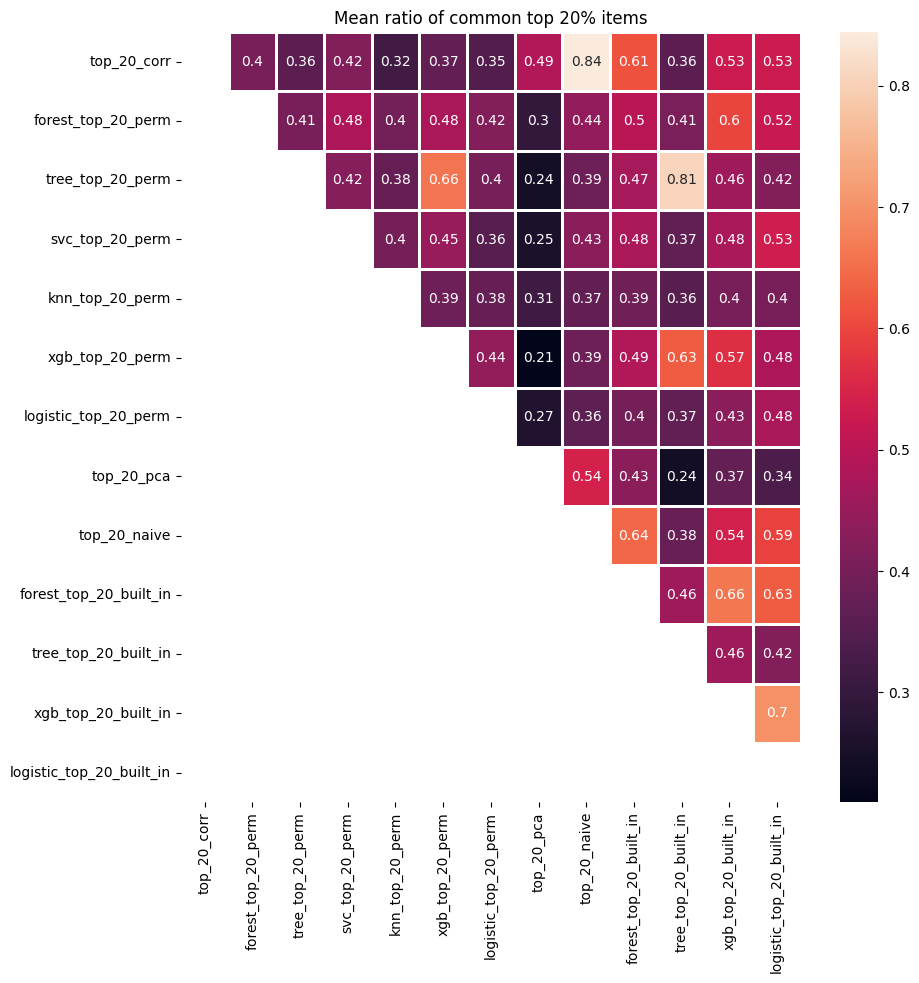

In [ ]:
#@title
#confusion matrix of mean ratio of common top 20% items, across all datasets

temp = np.zeros((len(lists),len(lists)))
for i,elem1 in enumerate(lists):
  for j,elem2 in enumerate(lists):
    sum = 0
    for n,name in enumerate(names):
      a = set(globals()[elem1][n])
      b = set(globals()[elem2][n])
      sum += (len(a & b)/len(a))*items[n]
    temp[i][j] = sum/items_sum

common_matrix = pd.DataFrame(temp, columns = lists, index = lists)
mask = np.tril(np.ones_like(common_matrix))

plt.figure(figsize=(10,10))
heat_map = sns.heatmap(common_matrix, linewidth = 1 , annot = True, mask = mask)
plt.title( "Mean ratio of common top 20% items" )
plt.show()

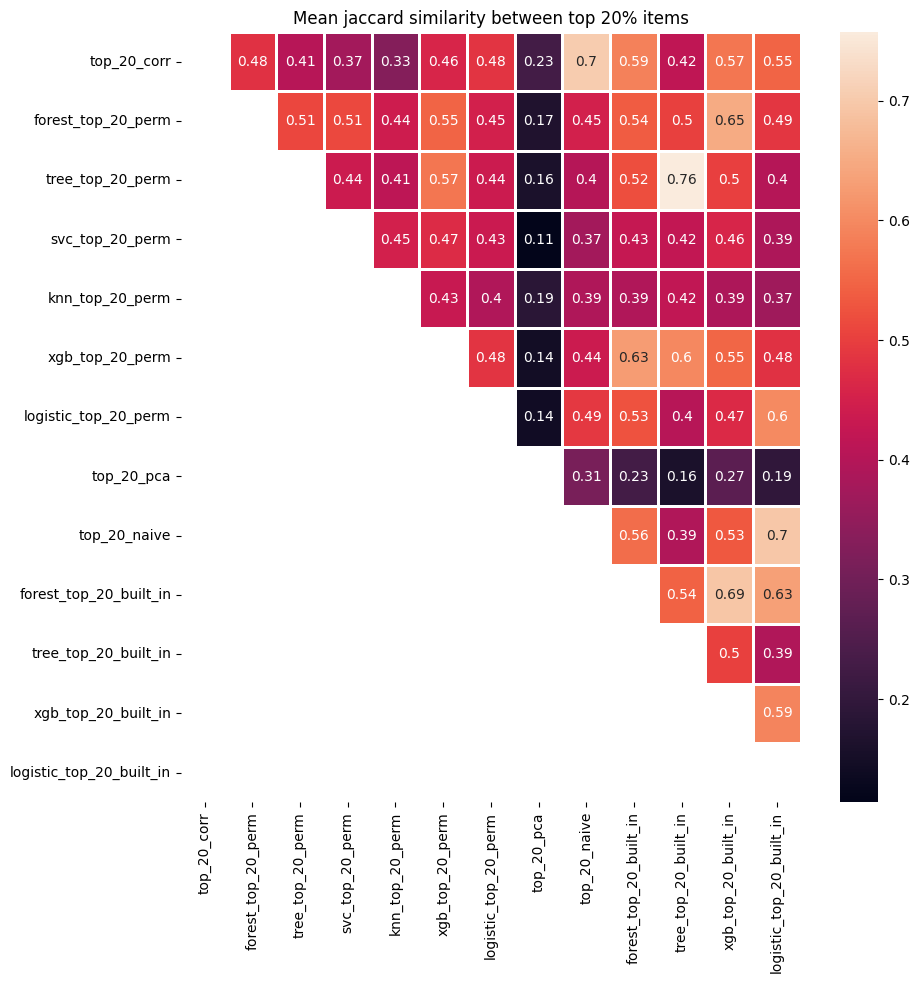

In [ ]:
#@title
#confusion matrix of mean Jaccard similarity between top 20% items' lists, across all datasets

temp = np.zeros((len(lists),len(lists)))
for i,elem1 in enumerate(lists):
  for j,elem2 in enumerate(lists):
    sum = 0
    for n,name in enumerate(names):
      a = set(globals()[elem1][n])
      b = set(globals()[elem2][n])
      sum += jaccard_similarity(a,b)
    temp[i][j] = sum/len(names)

jaccard_matrix = pd.DataFrame(temp, columns = lists, index = lists)
mask = np.tril(np.ones_like(jaccard_matrix))

plt.figure(figsize=(10,10))
heat_map = sns.heatmap(jaccard_matrix, linewidth = 1 , annot = True, mask = mask)
plt.title( "Mean jaccard similarity between top 20% items" )
plt.show()

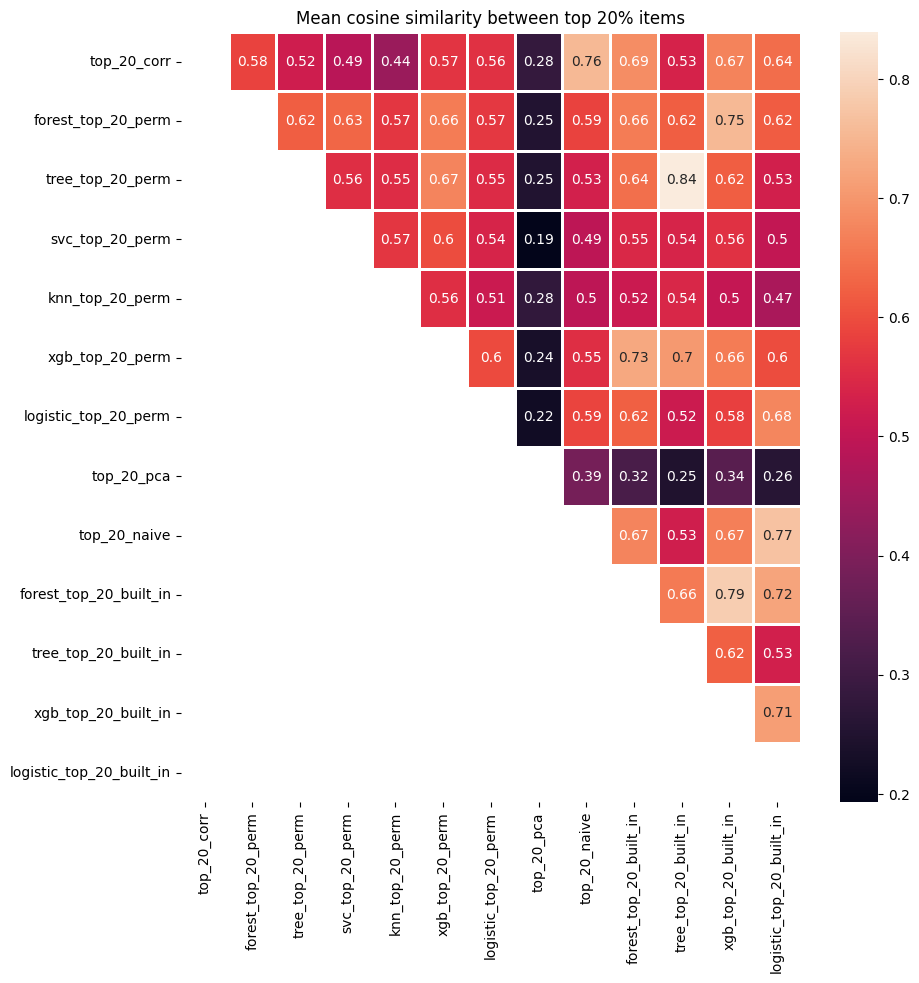

In [ ]:
#@title
#confusion matrix of mean cosine similarity between top 20% items' lists, across all datasets

temp = np.zeros((len(lists),len(lists)))
for i,elem1 in enumerate(lists):
  for j,elem2 in enumerate(lists):
    sum = 0
    for n,name in enumerate(names):
      a = [int(elem in globals()[elem1][n]) for elem in np.arange(items[n])]
      b = [int(elem in globals()[elem2][n]) for elem in np.arange(items[n])]
      sum += cosine_similarity(a,b)
    temp[i][j] = sum/len(names)

cosine_matrix = pd.DataFrame(temp, columns = lists, index = lists)
mask = np.tril(np.ones_like(cosine_matrix))

plt.figure(figsize=(10,10))
heat_map = sns.heatmap(cosine_matrix, linewidth = 1 , annot = True, mask = mask)
plt.title( "Mean cosine similarity between top 20% items" )
plt.show()

In the following plot, we observe how many times each item was selected by the feature selection methods. This can give us an indication of which items were preferred the most by our methods.

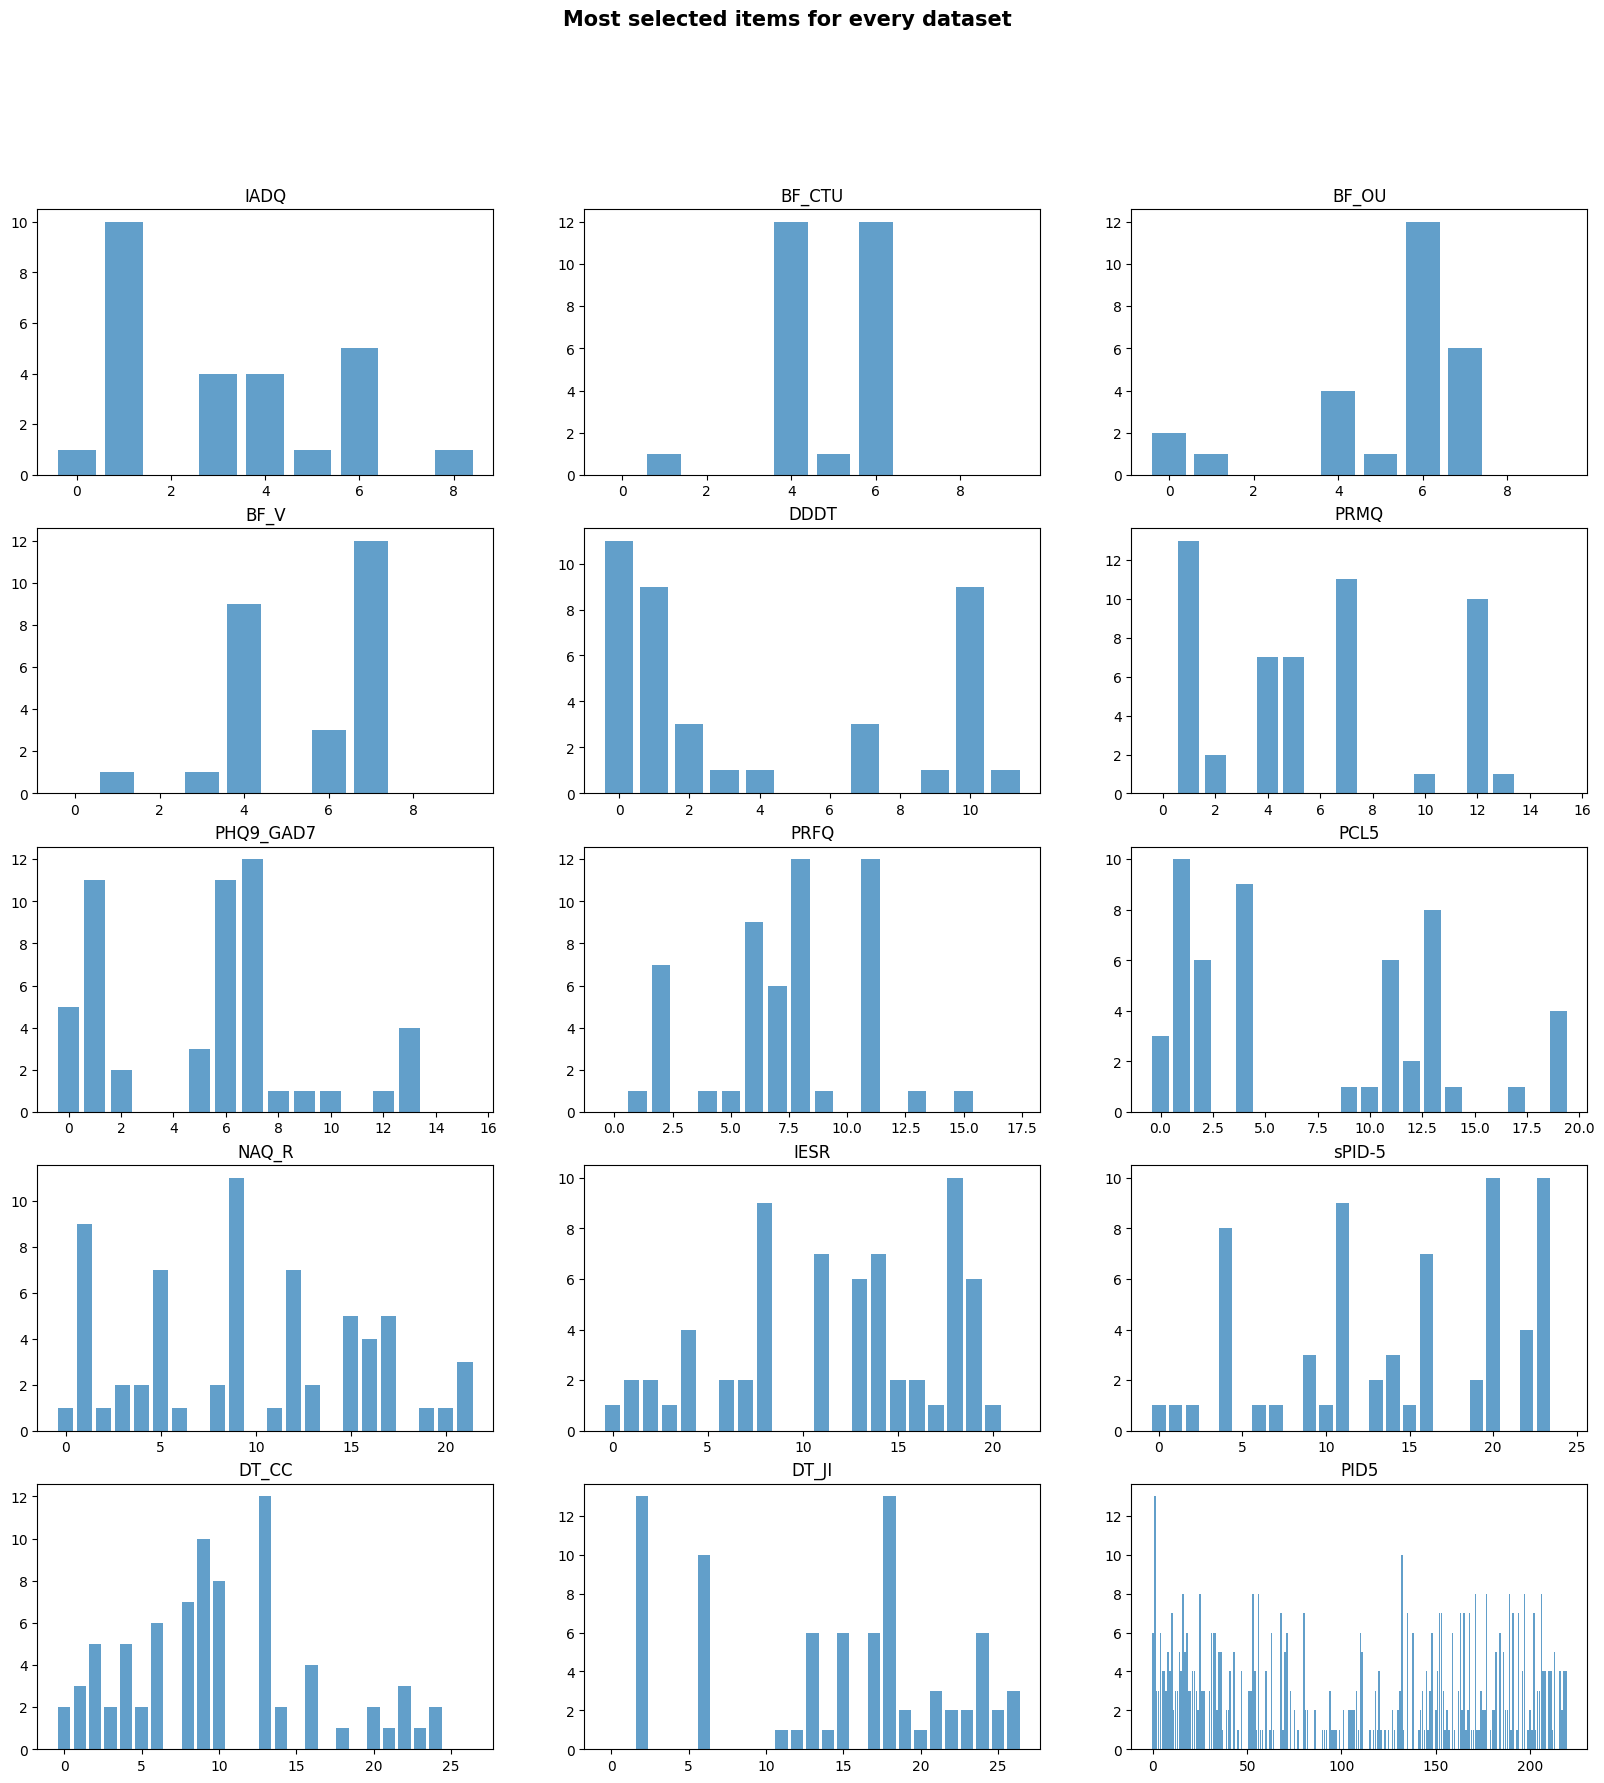

In [ ]:
#@title
#most selected items for every dataset

q_freq = []
for index, name in enumerate(names):
  temp = [0 for i in range(items[index])]
  for elem in lists:
    for i in range(items[index]):
      if i in globals()[elem][index]:
        temp[i] = temp[i] + 1
  q_freq.append(temp)

nrows = 5
ncols = 3

fig = plt.figure(figsize=(20, 20))
axes = fig.subplots(nrows=nrows, ncols=ncols)

for i in range(nrows):
    for j in range(ncols):
      n = i*ncols+j
      ax = axes[i][j]
      ax.bar(np.arange(items[n]),q_freq[n], alpha = 0.7)

      ax.set_title(names[n])

fig.suptitle("Most selected items for every dataset",  fontsize=15, fontweight='bold')
plt.show()

## Conclusions

In conclusion, this project has shown promising results in accurately identifying malingering people in psychological tests. Our model were able to achieve a high level of accuracy for classification even when using only a fifth of the features. In particular whe have seen that simple feature selection methods, like the one based only on the mean difference of the responses, can compete with classical and established feature extraction methods. The future work should probably focus on those datasets found to be more difficult to classify.





#Appendix: detect patological people



In this last section, we will provide a naive model, whose aim is to find out who, among the participants, is lying during his/her honest review.
For every question, we compute the mean answer for both honest and dishonest reviews.
The questions with the highest gaps between these two are felt as more important from the participants.

In [ ]:
#re-import datasets, given that they were previously normalized
names = ["DT_CC","DT_JI","PRMQ","PCL5","NAQ_R","PHQ9_GAD7","PID5","sPID-5","PRFQ","IESR","DDDT","IADQ","BF_CTU","BF_OU","BF_V"]
faking_list = ['good','good','bad','bad','bad','bad','bad','bad','good','bad','good','bad','good','good','good']

sep = [0,1,0,1,1,1,1,0,0,0,0,0,0,0,0]
seps = [",",";"]
for name,sep in zip(names,sep):
  url = "https://raw.githubusercontent.com/Berga53/cognitive/main/{}.csv".format(name)
  #full dataset
  globals()[name] = pd.read_csv(url, sep=seps[sep])
  #only honests dataset
  globals()[name+"_honest_2"] = globals()[name][globals()[name]['CONDITION'] == 'H']
  #only dishonests dataset
  globals()[name+"_dishonest_2"] = globals()[name][globals()[name]['CONDITION'] == 'D']
  #set the same indexes to better compare honest and dishonest responses for every responder
  globals()[name+"_dishonest_2"].set_index(globals()[name+"_honest_2"].index, inplace = True)

#drop NAQ_R entries with condition "P", not involved in our research scope
NAQ_R = NAQ_R[(NAQ_R['CONDITION'] == 'H') | (NAQ_R['CONDITION'] == 'D')]



In [ ]:
#this for cycle iterates the whole procedure over all the datasets

for name in names:
  #delete the last column, which tells if the answers are honest or dishonest, because it is not a numeric value
  globals()["X_"+name+"_honest"] = globals()[name+"_honest_2"].iloc[:, 0:globals()[name+"_honest_2"].shape[1]-1].to_numpy()
  globals()["X_"+name+"_dishonest"] = globals()[name+"_dishonest_2"].iloc[:,0:globals()[name+"_dishonest_2"].shape[1]-1].to_numpy()

  #compute mean answers for every question
  globals()[name+"_honest_sum"] = np.mean(globals()["X_"+name+"_honest"], axis = 0) #mean for honest
  globals()[name+"_dishonest_sum"] = np.mean(globals()["X_"+name+"_dishonest"], axis = 0) #mean for dishonest

  #compute gaps, here here called distances
  globals()[name+"_distances"] = np.abs(globals()[name+"_dishonest_sum"] - globals()[name+"_honest_sum"])

  #create a dataframe for every dataset, with mean answers and gaps
  globals()["rslt_"+name+"_dataframe"] = pd.DataFrame(data = np.reshape(np.concatenate((globals()[name+"_honest_sum"], globals()[name+"_dishonest_sum"], globals()[name+"_distances"]), axis = 0), (3,globals()["X_"+name+"_honest"].shape[-1])), columns = globals()[name+"_honest_2"].columns[0:globals()[name+"_honest_2"].shape[-1]-1], index = ['honest', 'dishonest', 'distances'])
  #globals()["rslt_"+name+"_dataframe"] = globals()["rslt_"+name+"_dataframe"].sort_values(by = 'distances', axis = 1, ascending = False)


Let's take for example the PID5 dataset, a test in which it was asked to fake mental diseases (fake bad). In this questionnaire, the answers go from 0 to 3.
If we consider the proposition 139, which states "I have seen things that actually were not real", the mean honest respond is 0.33, while the mean dishonest respond is 2.25, with a gap of 1.91.
This means that the question is felt as crucial from the participants.

Instead, the proposition 102, which states "I'm a really emotive person", has very close mean responds, 1.77 for the honest and 1.72 for the dishonest, meaning that this question is not felt as crucial.


In the next cell, we will reduce the number of features, by taking into account only the most relevant ones, that are the ones with the highest gap value.
Given that the answers to every dataset are natural numbers, it was decided to put the threshold at 1.5, which tells that, on average, the dishonest and the honest answer assume detached values.

In [ ]:
#the for cycle iterates the whole procedure over all the datasets

number_of_cols = [] #list which keeps trace of the number of selected features for every dataset

for i, name in enumerate(names):

  #reduce the results dataset by considering only important features
  globals()["reduced_results_"+name] = globals()["rslt_"+name+"_dataframe"][globals()["rslt_"+name+"_dataframe"].columns[globals()["rslt_"+name+"_dataframe"].iloc[2] >=1.5]]

  #reduce the honest dataset by considering only those features
  globals()["reduced_honest_"+name] = globals()[name+"_honest_2"][globals()["reduced_results_"+name].columns]

  #update the list of important features
  number_of_cols.append(globals()["reduced_honest_"+name].shape[1])



#we visualize how much this selection affected the dataset
print("Number of selected columns for each dataset, over total columns")
print(f"{'Dataset' : <10}{'selected ' : ^10}{'total ' : ^10}{'type of faking ': ^10}")
for i, name in enumerate(names):
  print(f"{name : <10}{number_of_cols[i] : ^10}{globals()[name].shape[-1]-1: ^10}{faking_list[i]: ^10}")

Number of selected columns for each dataset, over total columns
Dataset   selected    total   type of faking 
DT_CC         0         27       good   
DT_JI         0         27       good   
PRMQ          9         16       bad    
PCL5          6         20       bad    
NAQ_R         22        22       bad    
PHQ9_GAD7     14        16       bad    
PID5          53       220       bad    
sPID-5        14        25       bad    
PRFQ          4         18       good   
IESR          20        22       bad    
DDDT          0         12       good   
IADQ          0         9        bad    
BF_CTU        0         10       good   
BF_OU         1         10       good   
BF_V          0         10       good   


As we can note, all datasets regarding faking good, except for PRFQ , presented 0 or 1 selected features, meaning that in these cases the answers are not highly different, on average, between honest and dishonest responds.

The opposite behaviour, instead, affects datasets regarding faking bad, except for IADQ. The dataset NAQ_R, for example, maintains all its items.

We can explain this phenomenon by assuming that, in the datasets concerning faking bad, people are more likely to give detached answers between honest and dishonest reviews, trying to simulate bad behaviours and sometimes ending up exaggerating them.

In [ ]:
#restrict the list of dataset to whom with more than one suspicious feature. They are 8
restricted_names = []
restricted_number_of_cols = []
for i in range(len(names)):
  if number_of_cols[i] > 1:
    restricted_names.append(names[i])
    restricted_number_of_cols.append(number_of_cols[i])

With the following two lines, we want to compare every participant honest review with the average dishonest. The answers which are bigger or equal than the mean of the dishonest reviews are considered suspicious, highlighting a malingering pattern in that one participant.

In [ ]:
#we iterate over the restricted list of dataset, the ones with several selected questions
for name in restricted_names:

  #compute the difference between honest answers and dishonest mean answer, for every question
  globals()["detect_mad_"+name] = globals()["reduced_honest_"+name] - (globals()["reduced_results_"+name].iloc[1])

  #count how many suspicious answers every participant has collected
  globals()["count_mad_stat_"+name] = ( globals()["detect_mad_"+name].round() >= 0 ).sum(axis=1)

Let's grafically see our results.

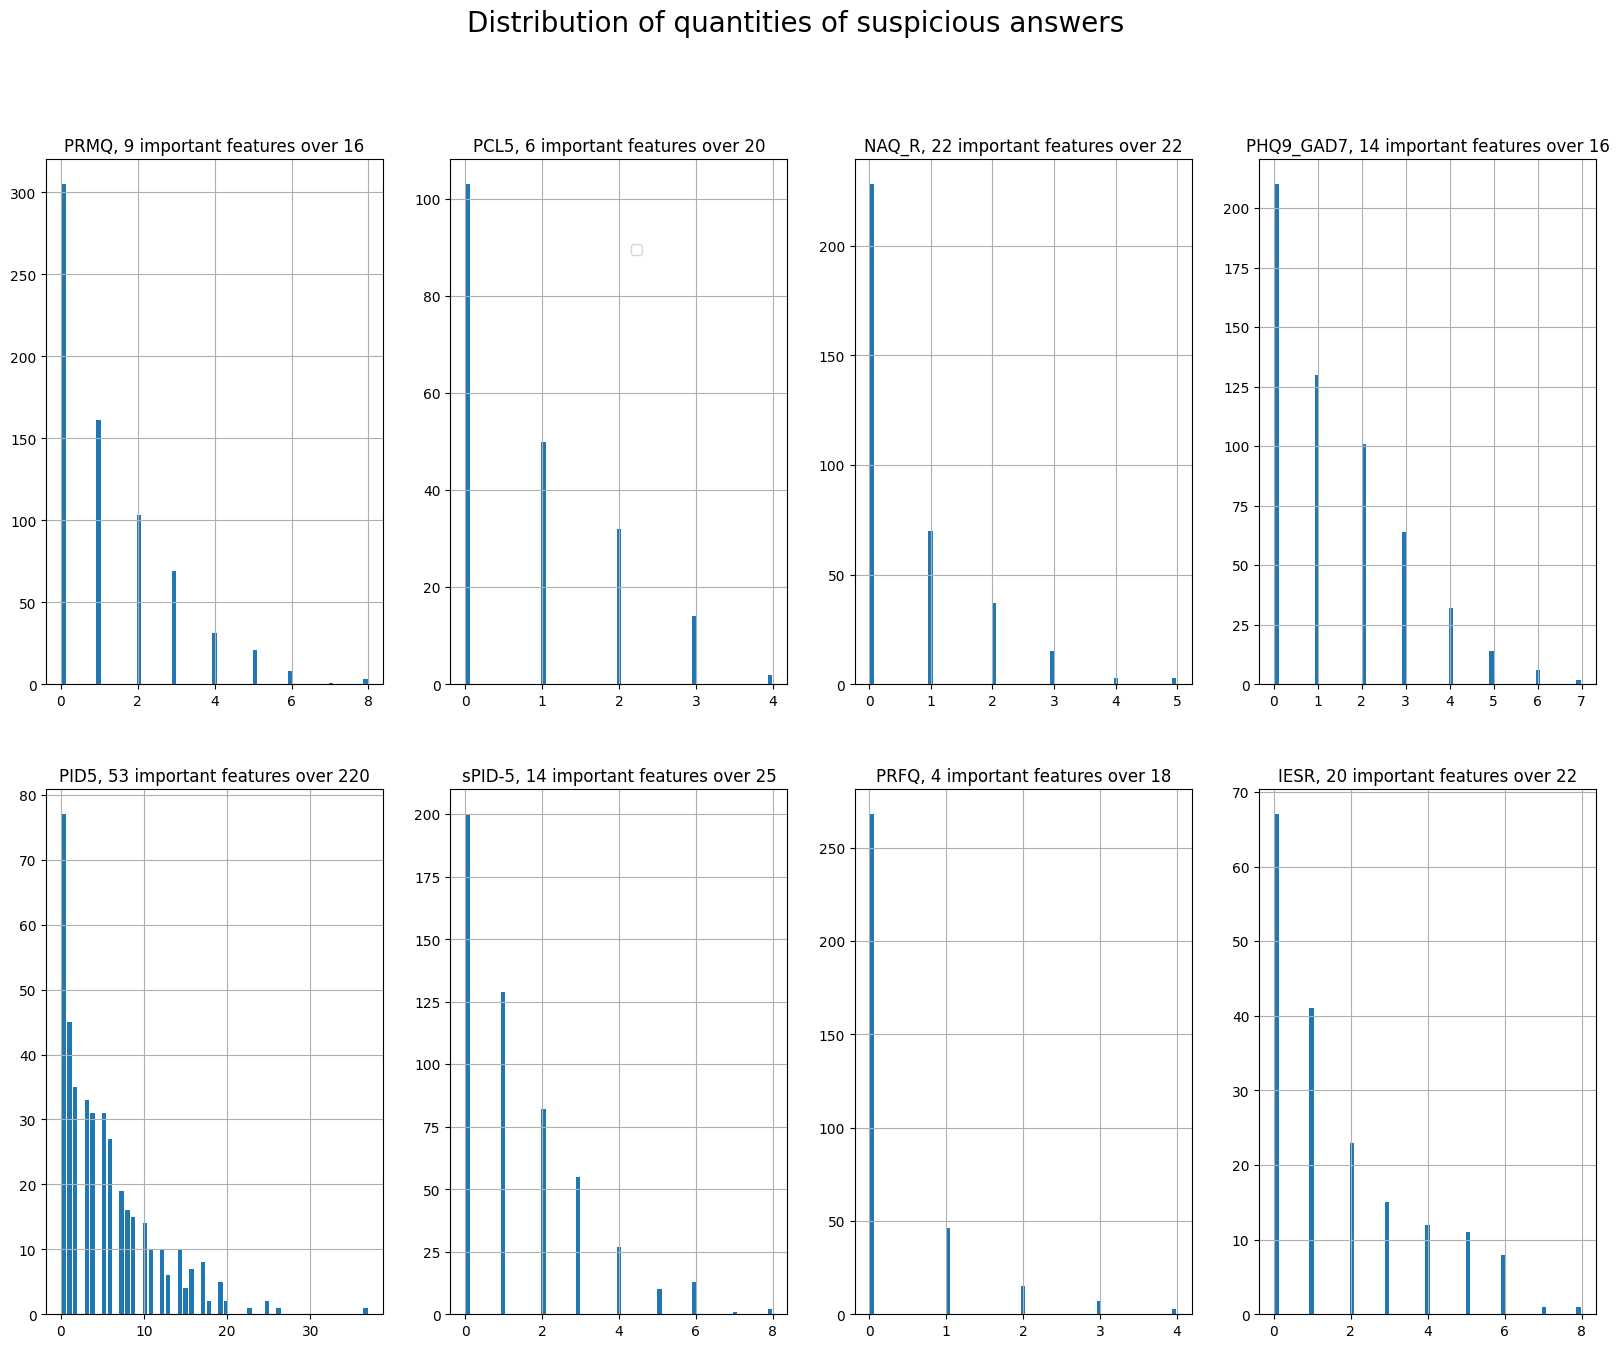

In [ ]:
#plot the distributions of how many suspicious answers were given by each honest review
nrows = 2
ncols = 4

fig = plt.figure(figsize=(20, 15))
axes = fig.subplots(nrows=nrows, ncols=ncols)

for i in range(nrows):
    for j in range(ncols):
      n = i*ncols+j
      if n < len(restricted_names) :
        ax = axes[i][j]
        globals()["count_mad_stat_"+restricted_names[n]].hist(ax = ax, rwidth = 0.75, bins =53)
        ax.set_title(restricted_names[n]+", "+str(restricted_number_of_cols[n])+" important features over "+str(globals()[restricted_names[n]].shape[-1]-1))

fig.suptitle("Distribution of quantities of suspicious answers", fontsize=20)
fig.legend(loc = 10, bbox_to_anchor= (0.42, 0.82), ncol = 2)
plt.show()

Seven datasets considered above deal with mental problems, to go more into detail we have:

1) PRMQ, dealing with memory deficit

2) PCL5, dealing with post-traumatic stress disorder

3) NAQ_R, dealing with mobbing

4) PHQ9_GAD7, dealing with anxious-depressive syndrome

5,6) PID5 and sPID5, dealing with mental disorder

7) IESR, dealing with post-traumatic stress disorder

PRFQ is the only one regarding faking good, dealing with children custody.

If we take, for example, the dataset PID5, we can see that one participant has collected 38 suspicious answers over 53 selected questions. This can make us think that this person could really be affected by mental disorders.

For a future work, it would be interesting to gather data coming from people who suffer from the mental  illnesses referred to in our questionnaires, in order to compare them with people who have given suspicious answers.